# 📊 Handling Outliers using Visualization Libraries 📊
### This is the third notebook of my capstone project.

In [640]:
%pip install termcolor

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [641]:
%pip install shapely

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [642]:
%pip install -U scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [643]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize
import re

import requests
import geopy
from geopy.geocoders import Nominatim

import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline
# %matplotlib notebook

plt.rcParams["figure.figsize"] = (10, 6)
# plt.rcParams['figure.dpi'] = 100

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### I'll define some User Defined Functions (DEFs) that I find useful.

In [644]:
# User Defined Function for first-looking to the features/columns

def first_looking(col):
    print("COLUMN NAME    : ", col)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("--------------------------------")
    print(df[col].value_counts(dropna = False))

In [645]:
def fill_most(df, group_col, col_name):
    '''Fills the missing values with the most existing value (mode) in the relevant column according to single-stage grouping'''
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        mode = list(df[cond][col_name].mode())
        if mode != []:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[cond][col_name].mode()[0])
        else:
            df.loc[cond, col_name] = df.loc[cond, col_name].fillna(df[col_name].mode()[0])
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False))

In [646]:
def fill_prop(df, group_col, col_name):
    for group in list(df[group_col].unique()):
        cond = df[group_col]==group
        df.loc[cond, col_name] = df.loc[cond, col_name].fillna(method="ffill").fillna(method="bfill")
    df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False))

In [647]:
def fill(df, group_col1, group_col2, col_name, method): # method can be either "mode" or "mean" or "median" or "ffill"
    
    '''Fills the missing values with "mode/mean/median/ffill/bfill method" according to double-stage grouping'''
    
    if method == "mode":
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond1 = df[group_col1]==group1
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                mode1 = list(df[cond1][col_name].mode())
                mode2 = list(df[cond2][col_name].mode())
                if mode2 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond2][col_name].mode()[0])
                elif mode1 != []:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[cond1][col_name].mode()[0])
                else:
                    df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(df[col_name].mode()[0])

    elif method == "mean":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("mean"), inplace = True)
        df[col_name].fillna(df[col_name].mean(), inplace = True)
        
    elif method == "median":
        df[col_name].fillna(df.groupby([group_col1, group_col2])[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df.groupby(group_col1)[col_name].transform("median"), inplace = True)
        df[col_name].fillna(df[col_name].median(), inplace = True)
        
    elif method == "ffill":           
        for group1 in list(df[group_col1].unique()):
            for group2 in list(df[group_col2].unique()):
                cond2 = (df[group_col1]==group1) & (df[group_col2]==group2)
                df.loc[cond2, col_name] = df.loc[cond2, col_name].fillna(method="ffill").fillna(method="bfill")
                
        for group1 in list(df[group_col1].unique()):
            cond1 = df[group_col1]==group1
            df.loc[cond1, col_name] = df.loc[cond1, col_name].fillna(method="ffill").fillna(method="bfill")            
           
        df[col_name] = df[col_name].fillna(method="ffill").fillna(method="bfill")
    
    
    print("COLUMN NAME    : ", col_name)
    print("--------------------------------")
    print("per_of_nulls   : ", "%", round(df[col_name].isnull().sum()*100 / df.shape[0], 2))
    print("num_of_nulls   : ", df[col_name].isnull().sum())
    print("num_of_uniques : ", df[col_name].nunique())
    print("--------------------------------")
    print(df[col_name].value_counts(dropna = False))

### Outliers are extreme values that stand out greatly from the overall pattern of values in a dataset or graph.

### Let's get down the biznness

In [648]:
df0 = pd.read_csv("C:/Users/ihsankoo/Desktop/Data Preprocessing/Part-2-Data-Imputing-Completed")

In [649]:
df = df0.copy()

In [650]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26947 entries, 0 to 26946
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               26947 non-null  int64  
 1   make_model               26947 non-null  object 
 2   make                     26947 non-null  object 
 3   model                    26947 non-null  object 
 4   price                    26947 non-null  int64  
 5   body_type                26947 non-null  object 
 6   type                     26947 non-null  object 
 7   doors                    26947 non-null  float64
 8   warranty                 26947 non-null  object 
 9   mileage                  26947 non-null  float64
 10  gearbox                  26947 non-null  object 
 11  fuel_type                26947 non-null  object 
 12  seller                   26947 non-null  object 
 13  seats                    26947 non-null  float64
 14  engine_size           

In [651]:
df.price = df.price.astype(float)

In [652]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [653]:
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

def check_obj_columns(df):
    '''
    Returns NO PROBLEM or column/s which has/have mixed object types.
    '''    
    
    tdf = df.select_dtypes(include=['object']).applymap(type)
    for col in tdf:
        if len(set(tdf[col].values)) > 1:
            print("Column" + " " + color.BOLD + color.RED + col + color.END + " " + "has mixed object types." )
    else:
        if len(set(tdf[col].values)) == 1:
            print(color.BOLD + color.GREEN + " " + "NO PROBLEM" + " " + color.END + " " + "with the data types of Columns in the DataFrame.")

check_obj_columns(df)

Column energy_efficiency_class has mixed object types.
 NO PROBLEM  with the data types of Columns in the DataFrame.


In [654]:
df.energy_efficiency_class.value_counts(dropna=False)

efficient      17395
unefficient     9551
NaN                1
Name: energy_efficiency_class, dtype: int64

In [655]:
df[df.energy_efficiency_class.isna()].T

,16799
make_model,Toyota Corolla
make,Toyota
model,Corolla
price,33999.000
body_type,Compact
type,Demonstration
doors,5.000
warranty,Available
mileage,2494.000
gearbox,Automatic


In [656]:
# Based on its co_emission being 89 which is average for efficient energy_efficiency_class, I'll fill it with efficient value

In [657]:
df.energy_efficiency_class.replace({np.nan:"efficient"}, inplace=True)

In [658]:
df.energy_efficiency_class.value_counts(dropna=False)

efficient      17396
unefficient     9551
Name: energy_efficiency_class, dtype: int64

In [659]:
df.energy_efficiency_class = df.energy_efficiency_class.astype(str)

In [660]:
check_obj_columns(df)

 NO PROBLEM  with the data types of Columns in the DataFrame.


In [661]:
df.isnull().sum()

make_model                 0
make                       0
model                      0
price                      0
body_type                  0
type                       0
doors                      0
warranty                   0
mileage                    0
gearbox                    0
fuel_type                  0
seller                     0
seats                      0
engine_size                0
gears                      0
co_emissions               0
drivetrain                 0
cylinders                  0
num_comfort_convenience    0
num_safety_security        0
num_extras                 0
empty_weight               0
full_service_history       0
non_smoker_vehicle         0
upholstery                 0
previous_owner             0
energy_efficiency_class    0
power_kW                   0
power_hp                   0
fuel_consumption_avg       0
age                        2
country                    0
multimedia                 0
dtype: int64

In [662]:
df[df.age.isna()].T

,681,16799
make_model,Mercedes-Benz E 53 AMG,Toyota Corolla
make,Mercedes-Benz,Toyota
model,E 53 AMG,Corolla
price,108900.000,33999.000
body_type,Convertible,Compact
type,Demonstration,Demonstration
doors,2.000,5.000
warranty,Available,Available
mileage,3856.000,2494.000
gearbox,Automatic,Automatic


In [663]:
df[['mileage', 'age']].sample(20)

,mileage,age
851,94987.000,5.000
3014,62703.000,7.000
17182,440.000,0.000
15091,28950.000,4.000
24724,8600.000,2.000
21278,79000.000,5.000
4574,108165.000,8.000
7085,125200.000,6.000
24071,7850.000,1.000
12464,143464.000,2.000


In [664]:
df.age.replace({np.nan:1}, inplace=True)

In [665]:
df.isna().sum()

make_model                 0
make                       0
model                      0
price                      0
body_type                  0
type                       0
doors                      0
warranty                   0
mileage                    0
gearbox                    0
fuel_type                  0
seller                     0
seats                      0
engine_size                0
gears                      0
co_emissions               0
drivetrain                 0
cylinders                  0
num_comfort_convenience    0
num_safety_security        0
num_extras                 0
empty_weight               0
full_service_history       0
non_smoker_vehicle         0
upholstery                 0
previous_owner             0
energy_efficiency_class    0
power_kW                   0
power_hp                   0
fuel_consumption_avg       0
age                        0
country                    0
multimedia                 0
dtype: int64

In [666]:
df.duplicated().sum()

1750

In [667]:
numeric_col = df.select_dtypes(include="number")
display(numeric_col.columns)
numeric_col

Index(['price', 'doors', 'mileage', 'seats', 'engine_size', 'gears',
       'co_emissions', 'cylinders', 'num_comfort_convenience',
       'num_safety_security', 'num_extras', 'empty_weight', 'previous_owner',
       'power_kW', 'power_hp', 'fuel_consumption_avg', 'age'],
      dtype='object')

,price,doors,mileage,seats,engine_size,gears,co_emissions,cylinders,num_comfort_convenience,num_safety_security,num_extras,empty_weight,previous_owner,power_kW,power_hp,fuel_consumption_avg,age
0,16950.000,5.000,120200.000,5.000,1595.000,5.000,98.000,4.000,16.000,18.000,1.000,1270.000,2.000,75.000,102.000,3.800,6.000
1,80900.000,4.000,5000.000,5.000,1.000,9.000,0.000,4.000,27.000,24.000,6.000,2355.000,0.000,215.000,292.000,5.300,0.000
2,69900.000,5.000,18900.000,5.000,1991.000,8.000,162.000,4.000,5.000,6.000,1.000,1555.000,2.000,310.000,421.000,8.400,2.000
3,46990.000,5.000,18995.000,5.000,1991.000,7.000,169.000,4.000,4.000,5.000,1.000,1455.000,2.000,225.000,306.000,7.300,2.000
4,16800.000,5.000,197000.000,5.000,2143.000,7.000,162.000,4.000,5.000,6.000,1.000,1545.000,2.000,100.000,136.000,4.900,7.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26942,37600.000,4.000,40345.000,4.000,1969.000,8.000,0.000,4.000,5.000,8.000,1.000,2077.000,2.000,288.000,392.000,2.000,3.000
26943,5499.000,4.000,145000.000,5.000,2435.000,5.000,217.000,5.000,9.000,10.000,2.000,1357.000,3.000,125.000,170.000,9.100,18.000
26944,7300.000,3.000,96000.000,4.000,1560.000,6.000,99.000,4.000,10.000,15.000,3.000,1356.000,1.000,84.000,114.000,3.800,11.000
26945,29900.000,4.000,94343.000,5.000,1969.000,8.000,149.000,4.000,16.000,9.000,2.000,1617.000,1.000,187.000,254.000,6.500,5.000


### I'll start column by column analysis

# price

In [668]:
first_looking("price")

COLUMN NAME    :  price
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  5021
--------------------------------
12990.000    218
14990.000    211
16990.000    177
19990.000    167
9990.000     156
            ... 
28100.000      1
34199.000      1
19112.000      1
30465.000      1
4440.000       1
Name: price, Length: 5021, dtype: int64


In [669]:
df.price.describe()

count     26947.000
mean      23310.578
std       25558.878
min         490.000
25%       11990.000
50%       17900.000
75%       27790.000
max     1346900.000
Name: price, dtype: float64

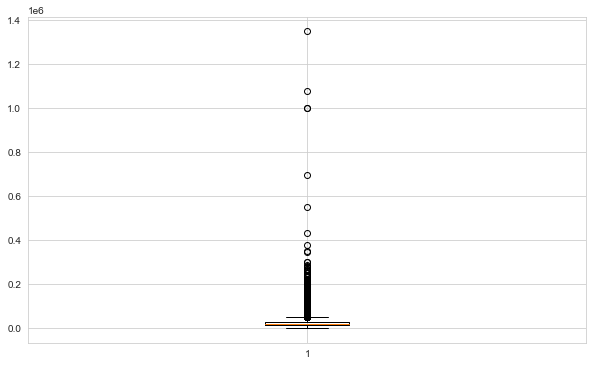

In [670]:
plt.boxplot(df.price)
plt.show()

In [671]:
df.price.sort_values().tail(20)

1396     259880.000
19224    264900.000
1412     267810.000
1318     268900.000
1112     279000.000
1443     279063.000
708      283900.000
1596     284780.000
1450     299000.000
1073     299000.000
1303     344900.000
21835    349000.000
1315     375900.000
21513    430000.000
21458    549000.000
1212     696900.000
21827    998000.000
26497    999999.000
21686   1075900.000
21701   1346900.000
Name: price, dtype: float64

In [672]:
df.price.sort_values().tail(20).index

Int64Index([ 1396, 19224,  1412,  1318,  1112,  1443,   708,  1596,  1450,
             1073,  1303, 21835,  1315, 21513, 21458,  1212, 21827, 26497,
            21686, 21701],
           dtype='int64')

In [673]:
df.iloc[[1396, 19224,  1412,  1318,  1112,  1443,   708,  1596,  1450,
             1073,  1303, 21835,  1315, 21513, 21458,  1212, 21827, 26497,
            21686, 21701]]

,make_model,make,model,price,body_type,type,doors,warranty,mileage,gearbox,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
1396,Mercedes-Benz G 63 AMG,Mercedes-Benz,G 63 AMG,259880.000,Off-Road/Pick-up,Demonstration,5.000,Available,9900.000,Automatic,...,Yes,Part/Full Leather,1.000,unefficient,430.000,585.000,16.000,0.000,Germany,Yes
19224,Nissan Skyline,Nissan,Skyline,264900.000,Coupe,Used,2.000,No Warranty,45000.000,Manual,...,No,Cloth,1.000,efficient,313.000,426.000,12.000,22.000,Spain,No
1412,Mercedes-Benz G 63 AMG,Mercedes-Benz,G 63 AMG,267810.000,Off-Road/Pick-up,Demonstration,5.000,No Warranty,3003.000,Automatic,...,Yes,Part/Full Leather,1.000,unefficient,430.000,585.000,14.400,0.000,Germany,Yes
1318,Mercedes-Benz G 63 AMG,Mercedes-Benz,G 63 AMG,268900.000,Off-Road/Pick-up,Pre-registered,5.000,Available,1800.000,Automatic,...,No,Part/Full Leather,0.000,unefficient,430.000,585.000,13.800,0.000,Spain,Yes
1112,Mercedes-Benz SLS,Mercedes-Benz,SLS,279000.000,Coupe,Used,2.000,Available,30000.000,Automatic,...,Yes,Part/Full Leather,1.000,efficient,420.000,571.000,13.200,12.000,Germany,No
1443,Mercedes-Benz G 63 AMG,Mercedes-Benz,G 63 AMG,279063.000,Off-Road/Pick-up,Demonstration,5.000,No Warranty,9900.000,Automatic,...,Yes,Part/Full Leather,1.000,unefficient,430.000,585.000,13.100,0.000,Germany,Yes
708,Mercedes-Benz AMG GT,Mercedes-Benz,AMG GT,283900.000,Convertible,Used,3.000,No Warranty,3569.000,Automatic,...,No,Part/Full Leather,1.000,unefficient,409.000,556.000,13.000,0.000,Austria,No
1596,Mercedes-Benz G 63 AMG,Mercedes-Benz,G 63 AMG,284780.000,Off-Road/Pick-up,Demonstration,5.000,No Warranty,9900.000,Automatic,...,Yes,Part/Full Leather,1.000,unefficient,430.000,585.000,16.000,0.000,Germany,Yes
1450,Mercedes-Benz GLE 63 AMG,Mercedes-Benz,GLE 63 AMG,299000.000,Off-Road/Pick-up,Demonstration,4.000,No Warranty,8000.000,Automatic,...,No,Part/Full Leather,1.000,unefficient,588.000,799.000,11.500,1.000,Germany,Yes
1073,Mercedes-Benz GLE 63 AMG,Mercedes-Benz,GLE 63 AMG,299000.000,Coupe,Demonstration,4.000,No Warranty,8000.000,Automatic,...,No,Part/Full Leather,1.000,unefficient,588.000,799.000,11.500,1.000,Germany,Yes


In [674]:
df['model'][21835]

'  '

In [675]:
df[df.model == '  ']

,make_model,make,model,price,body_type,type,doors,warranty,mileage,gearbox,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
162,Mercedes-Benz,Mercedes-Benz,,30490.000,Compact,Used,5.000,No Warranty,28539.000,Manual,...,No,Part/Full Leather,1.000,unefficient,85.000,116.000,3.900,1.000,France,Yes
184,Mercedes-Benz,Mercedes-Benz,,22790.000,Compact,Used,5.000,No Warranty,47638.000,Automatic,...,No,Part/Full Leather,1.000,efficient,80.000,109.000,3.900,5.000,France,No
186,Mercedes-Benz,Mercedes-Benz,,28790.000,Compact,Used,5.000,No Warranty,24045.000,Manual,...,No,Part/Full Leather,1.000,efficient,85.000,116.000,3.900,3.000,France,Yes
211,Mercedes-Benz,Mercedes-Benz,,18390.000,Compact,Used,5.000,No Warranty,66574.000,Manual,...,No,Part/Full Leather,1.000,efficient,66.000,90.000,3.900,5.000,France,No
213,Mercedes-Benz,Mercedes-Benz,,28290.000,Compact,Used,5.000,No Warranty,22888.000,Manual,...,No,Part/Full Leather,1.000,efficient,85.000,116.000,3.900,3.000,France,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25747,Volvo,Volvo,,11900.000,Coupe,Used,2.000,No Warranty,46000.000,Manual,...,No,Cloth,3.000,efficient,32.000,44.000,8.900,69.000,Germany,No
25762,Volvo,Volvo,,40000.000,Coupe,Used,2.000,Available,174000.000,Semi-automatic,...,No,Cloth,1.000,efficient,80.000,109.000,8.900,52.000,Italy,No
25887,Volvo,Volvo,,68890.000,Off-Road/Pick-up,Demonstration,5.000,No Warranty,3500.000,Automatic,...,Yes,Part/Full Leather,1.000,efficient,300.000,408.000,8.900,0.000,Germany,Yes
25903,Volvo,Volvo,,64900.000,Off-Road/Pick-up,Demonstration,5.000,No Warranty,5163.000,Automatic,...,Yes,Cloth,1.000,efficient,300.000,408.000,8.900,0.000,Germany,Yes


In [676]:
# There are values in model column that has two whitespaces, I took a note and will decide later what to with them.

In [677]:
df.loc[df["make_model"] == "Volvo 240"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]

,make_model,price,age,body_type,mileage,engine_size,gears,drivetrain
25624,Volvo 240,126950.000,40.000,Coupe,1.000,1999.000,1.000,Rear
25651,Volvo 240,15000.000,47.000,Coupe,170000.000,1999.000,5.000,Rear
25724,Volvo 240,17000.000,42.000,Coupe,109000.000,1999.000,4.000,Rear
26497,Volvo 240,999999.000,31.000,Station wagon,377733.000,2316.000,1.000,Rear
26498,Volvo 240,7950.000,29.000,Station wagon,231225.000,1986.000,1.000,Rear
26502,Volvo 240,5200.000,31.000,Station wagon,367329.000,1986.000,1.000,Rear
26823,Volvo 240,9850.000,36.000,Sedan,116569.000,2300.000,1.000,Rear


In [678]:
df.drop([25624, 26497], inplace=True)

In [679]:
df.loc[df["make_model"] == "Mercedes-Benz G 63 AMG"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]

,make_model,price,age,body_type,mileage,engine_size,gears,drivetrain
1212,Mercedes-Benz G 63 AMG,696900.000,0.000,Off-Road/Pick-up,100.000,3982.000,9.000,4WD
1247,Mercedes-Benz G 63 AMG,99980.000,7.000,Off-Road/Pick-up,23521.000,5461.000,7.000,4WD
1303,Mercedes-Benz G 63 AMG,344900.000,0.000,Off-Road/Pick-up,100.000,3982.000,9.000,4WD
1315,Mercedes-Benz G 63 AMG,375900.000,1.000,Off-Road/Pick-up,100.000,3982.000,9.000,4WD
1318,Mercedes-Benz G 63 AMG,268900.000,0.000,Off-Road/Pick-up,1800.000,3982.000,9.000,4WD
1357,Mercedes-Benz G 63 AMG,92380.000,9.000,Off-Road/Pick-up,49700.000,5461.000,7.000,4WD
1378,Mercedes-Benz G 63 AMG,119800.000,5.000,Off-Road/Pick-up,31000.000,5461.000,9.000,4WD
1392,Mercedes-Benz G 63 AMG,248800.000,0.000,Off-Road/Pick-up,8800.000,3982.000,9.000,4WD
1394,Mercedes-Benz G 63 AMG,92690.000,7.000,Off-Road/Pick-up,82178.000,5461.000,7.000,4WD
1396,Mercedes-Benz G 63 AMG,259880.000,0.000,Off-Road/Pick-up,9900.000,3982.000,9.000,4WD


In [680]:
df.drop([1212], inplace=True)

In [681]:
df.loc[df["make_model"] == "Ford GT"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]

,make_model,price,age,body_type,mileage,engine_size,gears,drivetrain
21458,Ford GT,549000.000,17.000,Coupe,20800.000,5409.000,6.000,Rear
21513,Ford GT,430000.000,17.000,Coupe,3166.000,4949.000,5.000,Rear
21551,Ford GT,169950.000,54.000,Coupe,202.000,4949.000,4.000,Rear
21552,Ford GT,129950.000,56.000,Coupe,33809.000,4949.000,5.000,Rear
21686,Ford GT,1075900.000,4.000,Coupe,145.000,4949.000,5.000,Rear
21701,Ford GT,1346900.000,1.000,Coupe,3500.000,4949.000,5.000,Rear
21827,Ford GT,998000.000,4.000,Coupe,1900.000,4949.000,5.000,Rear
21829,Ford GT,159500.000,45.000,Coupe,596.000,4949.000,5.000,Rear


In [682]:
df.loc[df["make_model"] == "Nissan Skyline"][["make_model", "price", "age", "body_type", "mileage", "engine_size", "gears", "drivetrain"]]

,make_model,price,age,body_type,mileage,engine_size,gears,drivetrain
19186,Nissan Skyline,64950.000,26.000,Coupe,148461.000,2740.000,5.000,Rear
19207,Nissan Skyline,35160.000,26.000,Coupe,114003.000,2500.000,5.000,Rear
19209,Nissan Skyline,83000.000,51.000,Coupe,86000.000,2500.000,5.000,Rear
19215,Nissan Skyline,34500.000,30.000,Coupe,29500.000,2000.000,5.000,Rear
19224,Nissan Skyline,264900.000,22.000,Coupe,45000.000,2500.000,5.000,Rear
19225,Nissan Skyline,51000.000,31.000,Coupe,117000.000,2600.000,5.000,4WD
19227,Nissan Skyline,149990.000,22.000,Coupe,52000.000,2500.000,6.000,Rear
19299,Nissan Skyline,159999.000,23.000,Coupe,68314.000,2598.000,6.000,4WD
19300,Nissan Skyline,36000.000,26.000,Coupe,122000.000,2500.000,5.000,Rear
19306,Nissan Skyline,65000.000,27.000,Coupe,25700.000,2600.000,5.000,4WD


In [683]:
df.drop(df[(df["make_model"] == "Nissan Skyline") & (df['price'] >= 140000)].index, inplace=True)

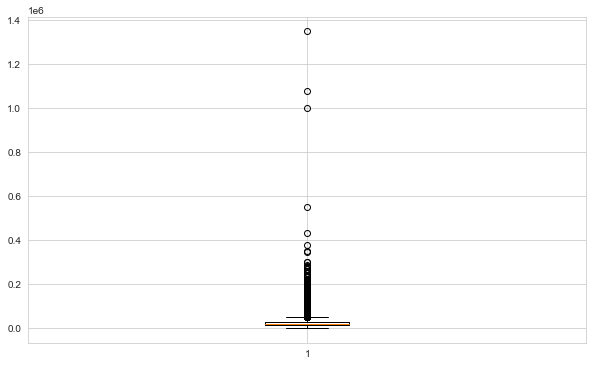

In [684]:
plt.boxplot(df.price)
plt.show()

# doors

In [685]:
first_looking("doors")

COLUMN NAME    :  doors
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  6
--------------------------------
5.000    16637
2.000     5214
4.000     2871
3.000     2212
6.000        5
1.000        2
Name: doors, dtype: int64


In [686]:
df[df.doors == 1]["make_model"]

10043    Fiat 124 Spider
21045        Ford Fiesta
Name: make_model, dtype: object

In [687]:
df[df["make_model"] == "Fiat 124 Spider"]

,make_model,make,model,price,body_type,type,doors,warranty,mileage,gearbox,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
9944,Fiat 124 Spider,Fiat,124 Spider,25750.000,Convertible,Used,2.000,No Warranty,119000.000,Manual,...,Yes,Part/Full Leather,1.000,unefficient,85.000,116.000,6.400,41.000,Germany,No
9945,Fiat 124 Spider,Fiat,124 Spider,21860.000,Convertible,Used,3.000,No Warranty,42171.000,Manual,...,Yes,Part/Full Leather,1.000,unefficient,103.000,140.000,6.400,5.000,Germany,Yes
9949,Fiat 124 Spider,Fiat,124 Spider,18488.000,Convertible,Used,2.000,No Warranty,69347.000,Manual,...,No,Cloth,1.000,unefficient,103.000,140.000,6.400,4.000,Germany,Yes
9951,Fiat 124 Spider,Fiat,124 Spider,23490.000,Convertible,Used,2.000,Available,20271.000,Manual,...,No,Part/Full Leather,2.000,unefficient,103.000,140.000,6.400,3.000,Germany,Yes
9952,Fiat 124 Spider,Fiat,124 Spider,19900.000,Convertible,Used,2.000,Available,14950.000,Manual,...,Yes,Part/Full Leather,2.000,unefficient,103.000,140.000,6.400,5.000,Germany,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10400,Fiat 124 Spider,Fiat,124 Spider,16121.000,Coupe,Used,2.000,No Warranty,125618.000,Manual,...,No,Part/Full Leather,1.000,unefficient,103.000,140.000,6.400,6.000,Spain,No
10401,Fiat 124 Spider,Fiat,124 Spider,16121.000,Coupe,Used,2.000,No Warranty,125618.000,Manual,...,No,Part/Full Leather,1.000,unefficient,103.000,140.000,6.400,6.000,Spain,No
10439,Fiat 124 Spider,Fiat,124 Spider,19900.000,Coupe,Used,2.000,No Warranty,82000.000,Manual,...,No,Part/Full Leather,2.000,unefficient,80.000,109.000,6.400,49.000,Italy,No
10522,Fiat 124 Spider,Fiat,124 Spider,20000.000,Coupe,Used,2.000,No Warranty,29000.000,Manual,...,No,Part/Full Leather,1.000,unefficient,100.000,136.000,6.400,6.000,Italy,No


In [688]:
df[df.doors == 6]["make_model"]

15912     Dacia Logan
16079     Dacia Logan
16087    Dacia Dokker
16110     Dacia Logan
16118     Dacia Logan
Name: make_model, dtype: object

In [689]:
df[df.make_model == "Dacia Logan"]["doors"]

15183   4.000
15245   4.000
15290   4.000
15301   4.000
15336   4.000
         ... 
16562   4.000
16564   4.000
16576   4.000
16583   4.000
16594   4.000
Name: doors, Length: 201, dtype: float64

In [690]:
df[df.make_model == "Dacia Dokker"]["doors"]

15364   4.000
15837   4.000
15852   4.000
15915   5.000
15918   5.000
15919   5.000
15922   5.000
15928   5.000
15930   5.000
15939   5.000
15948   5.000
15951   5.000
15953   5.000
15955   4.000
15957   5.000
15963   5.000
15969   5.000
15970   4.000
15971   4.000
15974   4.000
15975   4.000
15977   5.000
15988   4.000
16000   4.000
16003   4.000
16004   5.000
16019   5.000
16025   4.000
16027   4.000
16037   4.000
16038   4.000
16042   4.000
16049   4.000
16064   4.000
16074   4.000
16075   4.000
16080   4.000
16085   5.000
16087   6.000
16093   4.000
16100   5.000
16113   5.000
16122   5.000
16128   5.000
16130   5.000
16133   4.000
16136   5.000
16147   4.000
16165   5.000
16174   5.000
16184   4.000
16187   5.000
16188   5.000
16195   5.000
16208   5.000
16497   4.000
Name: doors, dtype: float64

In [691]:
df.doors.replace([1, 6], np.nan, inplace=True)

In [692]:
fill(df, "make_model", "body_type", "doors", "mode")

COLUMN NAME    :  doors
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  4
--------------------------------
5.000    16643
2.000     5215
4.000     2871
3.000     2212
Name: doors, dtype: int64


In [693]:
df.shape

(26941, 33)

In [694]:
# I decided to drop doors column because it's unrelative, what matters is the body_type

In [695]:
df.drop(columns=['doors'], inplace=True)

In [696]:
df.shape

(26941, 32)

# mileage

In [697]:
first_looking("mileage")

COLUMN NAME    :  mileage
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  14182
--------------------------------
10.000        518
1.000         158
5000.000      118
100.000       110
5.000         105
             ... 
116119.000      1
89601.000       1
100111.000      1
11648.000       1
230047.000      1
Name: mileage, Length: 14182, dtype: int64


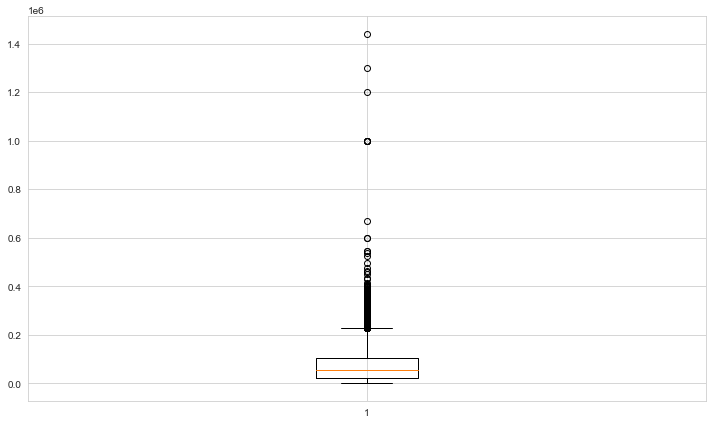

In [698]:
plt.boxplot(df.mileage)
plt.tight_layout()
plt.show()

In [699]:
df.mileage.sort_values().tail(20)

26545    448914.000
279      457379.000
6499     461626.000
20012    477000.000
3456     494457.000
18253    523992.000
3212     536388.000
14360    546888.000
17814    547000.000
14346    600000.000
26782    600001.000
13159    667128.000
3397     999999.000
10051    999999.000
21248    999999.000
7686    1000000.000
22797   1000001.000
12189   1199900.000
17239   1300000.000
18785   1440000.000
Name: mileage, dtype: float64

In [700]:
df[df['mileage'] > 500000][["make_model", "type", "mileage", "age"]]

,make_model,type,mileage,age
3212,Opel Kadett,Used,536388.000,44.000
3397,Opel Kadett,Used,999999.000,54.000
7686,Peugeot 404,Used,1000000.000,54.000
10051,Fiat,Used,999999.000,89.000
12189,SEAT Ibiza,Used,1199900.000,4.000
13159,SEAT Altea XL,Used,667128.000,12.000
14346,Skoda Superb,Used,600000.000,11.000
14360,Skoda Octavia,Used,546888.000,8.000
17239,Toyota Celica,Used,1300000.000,36.000
17814,Toyota Land Cruiser,Used,547000.000,23.000


In [701]:
drop_candidate = df[df['mileage'] > 500000][["make_model", "type", "mileage", "age"]].index
drop_candidate

Int64Index([ 3212,  3397,  7686, 10051, 12189, 13159, 14346, 14360, 17239,
            17814, 18253, 18785, 21248, 22797, 26782],
           dtype='int64')

In [702]:

df[(df['mileage'] > 500000) & (df['age'] < 5)]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
12189,SEAT Ibiza,SEAT,Ibiza,10200.000,Compact,Used,Available,1199900.000,Manual,Diesel,...,No,Cloth,1.000,efficient,70.000,95.000,3.700,4.000,Spain,No
18785,Nissan Micra,Nissan,Micra,14400.000,Compact,Used,No Warranty,1440000.000,Manual,Benzine,...,No,Cloth,4.000,unefficient,74.000,101.000,4.600,3.000,Spain,No
22797,Ford Fiesta,Ford,Fiesta,9990.000,Sedan,Used,Available,1000001.000,Manual,Benzine,...,Yes,Cloth,1.000,efficient,52.000,71.000,5.100,4.000,Germany,No


In [703]:

df[(df['mileage'] > 100000) & (df['age'] < 2)]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
19123,Nissan Micra,Nissan,Micra,3250.000,Convertible,Used,No Warranty,147985.000,Manual,Benzine,...,No,Part/Full Leather,1.000,efficient,81.000,110.000,6.600,-1.000,Netherlands,No


In [704]:
df.drop([12189, 18785, 22797, 19123], inplace=True)

# seats

In [705]:
first_looking('seats')

COLUMN NAME    :  seats
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  11
--------------------------------
5.000     19688
4.000      5449
2.000      1250
7.000       418
8.000        44
9.000        35
3.000        25
6.000        12
0.000         9
1.000         5
17.000        2
Name: seats, dtype: int64


In [706]:
df[(df.seats == 17)]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
4291,Opel Movano,Opel,Movano,59990.000,Station wagon,Used,Available,290.000,Manual,Diesel,...,Yes,Cloth,1.000,efficient,120.000,163.000,5.300,0.000,Germany,No
4296,Opel Movano,Opel,Movano,59990.000,Station wagon,Used,Available,300.000,Manual,Diesel,...,Yes,Cloth,1.000,efficient,120.000,163.000,5.300,0.000,Germany,No


In [707]:
df[(df.seats == 1)]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
5178,Renault,Renault,,6500.000,Compact,Used,Available,21400.000,Automatic,Electric,...,No,Part/Full Leather,1.000,efficient,1.000,1.000,5.400,4.000,Italy,Yes
5815,Renault Twizy,Renault,Twizy,3999.000,Coupe,Used,No Warranty,91900.000,Automatic,Electric,...,Yes,Part/Full Leather,3.000,efficient,8.000,11.000,5.300,7.000,Germany,No
6209,Renault Twizy,Renault,Twizy,7950.000,Off-Road/Pick-up,Used,No Warranty,35784.000,Automatic,Electric,...,No,Part/Full Leather,3.000,efficient,4.000,5.000,5.300,6.000,Netherlands,No
7561,Peugeot 308,Peugeot,308,10750.000,Convertible,Used,No Warranty,82000.000,Manual,Diesel,...,Yes,Part/Full Leather,2.000,efficient,100.000,136.000,6.800,12.000,France,Yes
10359,Fiat 131,Fiat,131,24500.000,Coupe,Used,Available,1.000,Manual,Benzine,...,No,Part/Full Leather,4.000,efficient,109.000,148.000,5.300,34.000,Belgium,No


In [708]:
df.iloc[5177].replace({"  ":"Twizy"}, inplace=True)

In [709]:
df[(df.make_model == 'Peugeot 308')]["seats"]

7139   5.000
7140   5.000
7143   5.000
7144   5.000
7145   5.000
        ... 
9531   5.000
9532   5.000
9543   5.000
9544   5.000
9545   5.000
Name: seats, Length: 543, dtype: float64

In [710]:
df.iloc[7560].replace({1:5}, inplace=True)

In [711]:
df.seats = df.seats.astype(float)

In [712]:
df[(df.make_model == "Fiat 131")][["make_model","body_type","seats", "price"]]

,make_model,body_type,seats,price
10359,Fiat 131,Coupe,1.000,24500.000
10403,Fiat 131,Coupe,2.000,214900.000
10428,Fiat 131,Coupe,4.000,14000.000
10524,Fiat 131,Coupe,5.000,22000.000


In [713]:
df.iloc[10402].replace({214900.0:21490.0}, inplace=True)

In [714]:
df[df.make_model == "Fiat 131"]["seats"] = 5

In [715]:
df[df.make_model == "Fiat 131"]["seats"]

10359   1.000
10403   2.000
10428   4.000
10524   5.000
Name: seats, dtype: float64

In [716]:
df.loc[df['make_model'] == 'Fiat 131', 'seats'] = 5.000

In [717]:
df[df.make_model == "Fiat 131"]["seats"]

10359   5.000
10403   5.000
10428   5.000
10524   5.000
Name: seats, dtype: float64

In [718]:
df.seats.value_counts()

5.000     19691
4.000      5448
2.000      1249
7.000       418
8.000        44
9.000        35
3.000        25
6.000        12
0.000         9
1.000         4
17.000        2
Name: seats, dtype: int64

In [719]:
df[df["seats"] == 0]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
4872,Renault Twingo,Renault,Twingo,7750.000,Compact,Used,Available,53335.000,Manual,Benzine,...,No,Cloth,3.000,unefficient,52.000,71.000,4.700,7.000,Germany,No
11982,SEAT Ibiza,SEAT,Ibiza,9900.000,Compact,Used,No Warranty,132390.000,Manual,Benzine,...,No,Cloth,1.000,efficient,103.000,140.000,4.700,7.000,Germany,No
12093,SEAT Ibiza,SEAT,Ibiza,14700.000,Compact,Used,Available,66510.000,Manual,Benzine,...,No,Cloth,2.000,efficient,85.000,116.000,4.700,4.000,Germany,No
12392,SEAT Ibiza,SEAT,Ibiza,10900.000,Coupe,Used,No Warranty,43231.000,Manual,Benzine,...,Yes,Cloth,2.000,unefficient,66.000,90.000,5.900,6.000,Germany,No
13485,SEAT Toledo,SEAT,Toledo,7650.000,Sedan,Used,No Warranty,124800.000,Manual,Benzine,...,No,Cloth,2.000,unefficient,63.000,86.000,5.100,8.000,Germany,No
13532,SEAT Ibiza,SEAT,Ibiza,18950.000,Sedan,Used,No Warranty,11400.000,Manual,Benzine,...,Yes,Cloth,1.000,unefficient,70.000,95.000,4.600,2.000,Germany,Yes
14966,Skoda Fabia,Skoda,Fabia,2900.000,Sedan,Used,Available,197000.000,Manual,Benzine,...,No,Cloth,2.000,unefficient,77.000,105.000,6.900,13.000,Germany,No
15092,Skoda Fabia,Skoda,Fabia,2950.000,Sedan,Used,Available,139877.000,Manual,Benzine,...,No,Cloth,2.000,efficient,63.000,86.000,6.500,14.000,Germany,No
24217,Hyundai i30,Hyundai,i30,8900.000,Station wagon,Used,No Warranty,114730.000,Manual,Diesel,...,No,Cloth,2.000,efficient,66.000,90.000,4.400,8.000,Germany,No


In [720]:
df.loc[df['seats'] == 0.0, 'seats'] = np.nan

In [721]:
df.seats.value_counts(dropna=False)

5.000     19691
4.000      5448
2.000      1249
7.000       418
8.000        44
9.000        35
3.000        25
6.000        12
NaN           9
1.000         4
17.000        2
Name: seats, dtype: int64

In [722]:
fill(df, "make_model", "body_type", "seats", "mode")

COLUMN NAME    :  seats
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  10
--------------------------------
5.000     19699
4.000      5449
2.000      1249
7.000       418
8.000        44
9.000        35
3.000        25
6.000        12
1.000         4
17.000        2
Name: seats, dtype: int64


In [723]:
df[(df.seats == 6)]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
1420,Mercedes-Benz G 230,Mercedes-Benz,G 230,30800.000,Off-Road/Pick-up,Used,No Warranty,100000.000,Automatic,Benzine,...,No,Part/Full Leather,1.000,efficient,85.000,116.000,5.300,29.000,Germany,No
1832,Mercedes-Benz EQV 300,Mercedes-Benz,EQV 300,94949.000,Station wagon,Demonstration,No Warranty,8000.000,Automatic,Electric,...,Yes,Part/Full Leather,1.000,efficient,150.000,204.000,5.300,0.000,Germany,Yes
1883,Mercedes-Benz C 43 AMG,Mercedes-Benz,C 43 AMG,47970.000,Station wagon,Used,No Warranty,49974.000,Automatic,Benzine,...,Yes,Part/Full Leather,1.000,unefficient,287.000,390.000,9.300,4.000,Germany,Yes
1911,Mercedes-Benz V 250,Mercedes-Benz,V 250,43990.000,Station wagon,Used,Available,105000.000,Automatic,Diesel,...,Yes,Cloth,2.000,efficient,140.000,190.000,6.000,5.000,Germany,No
2130,Mercedes-Benz C 200,Mercedes-Benz,C 200,30870.000,Sedan,Used,No Warranty,95412.000,Automatic,Diesel,...,Yes,Part/Full Leather,3.000,efficient,100.000,136.000,4.200,5.000,Germany,Yes
8760,Peugeot Traveller,Peugeot,Traveller,59900.000,Station wagon,Used,Available,3500.000,Automatic,Diesel,...,No,Part/Full Leather,1.000,efficient,132.000,179.000,5.200,0.000,Germany,No
16988,Toyota Land Cruiser,Toyota,Land Cruiser,25000.000,Convertible,Used,Available,120000.000,Manual,Diesel,...,No,Part/Full Leather,1.000,unefficient,66.000,90.000,10.000,47.000,Italy,No
17610,Toyota Land Cruiser,Toyota,Land Cruiser,66950.000,Off-Road/Pick-up,Pre-registered,Available,50.000,Manual,Benzine,...,Yes,Cloth,0.000,unefficient,167.000,227.000,15.600,0.000,Germany,No
21326,Ford Fairlane,Ford,Fairlane,49900.000,Convertible,Used,No Warranty,99500.000,Automatic,Benzine,...,Yes,Part/Full Leather,1.000,efficient,221.000,300.000,5.300,63.000,Germany,No
21722,Ford Mercury,Ford,Mercury,26750.000,Coupe,Used,No Warranty,124000.000,Automatic,Benzine,...,No,Part/Full Leather,2.000,efficient,218.000,296.000,5.300,65.000,Germany,No


In [724]:
df.shape

(26937, 32)

In [725]:
df.drop(columns = "seats", inplace=True)

In [726]:
df.shape

(26937, 31)

# engine_size

In [727]:
df.engine_size = df0.engine_size.copy()

In [728]:
first_looking("engine_size")

COLUMN NAME    :  engine_size
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  476
--------------------------------
1598.000    2224
999.000     1988
1969.000    1141
1461.000    1138
1998.000    1013
            ... 
2991.000       1
2980.000       1
2464.000       1
1565.000       1
2473.000       1
Name: engine_size, Length: 476, dtype: int64


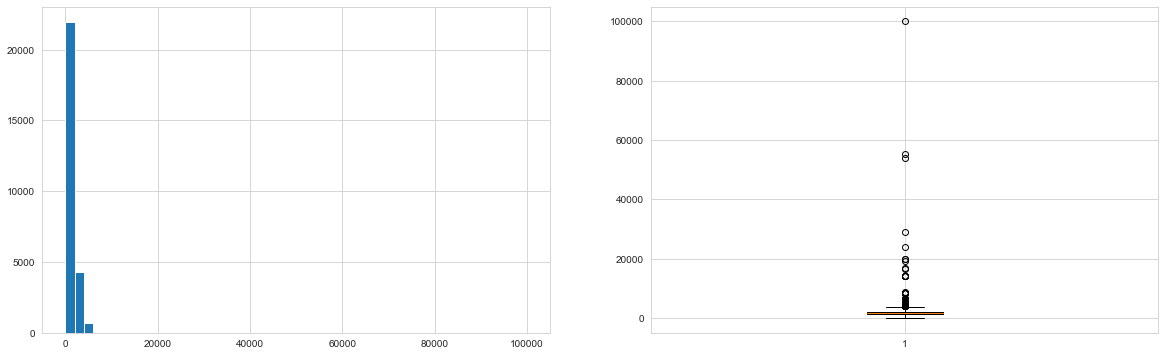

In [729]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["engine_size"], bins=50)

plt.subplot(122)
plt.boxplot(df["engine_size"], whis=2.5)

plt.show()

In [730]:
df["engine_size"].sort_values(ascending=False).head(23).unique()

array([99900., 55200., 54009., 29000., 23800., 20000., 19194., 16998.,
       16597., 14040.,  8660.,  8500.])

In [731]:
df["engine_size"].sort_values(ascending=True).head(800).unique()

array([  0.,   1.,   2.,   4.,   5.,  20., 200., 289., 300., 332., 498.,
       499., 500., 549., 600., 650., 652., 698., 750., 767., 839., 843.,
       847., 850., 875., 898.])

In [732]:
df["engine_size"].sort_values(ascending=False).head(25).index

Int64Index([16479, 24863, 21234, 19226,  9591, 20451, 20463,   714,  5580,
            16087,  5748,  5918,  5785,  5935,  5815, 21574,  6171,  4949,
             5145,  4844,  6209,  4892,  5431, 21705, 21560],
           dtype='int64')

In [733]:
outlier_engine_size = df["engine_size"].isin([99900., 55200., 54009., 29000., 23800., 20000., 19194., 16998.,
       16597., 14040.,  8660.,  8500., 4., 5., 20., 200., 289., 300., 332.])

In [734]:
df.loc[outlier_engine_size, "engine_size"] = np.nan

In [735]:
df["engine_size"].isnull().sum()

33

In [736]:
fill(df, "make_model", "body_type", "engine_size", "mode")

COLUMN NAME    :  engine_size
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  457
--------------------------------
1598.000    2237
999.000     1988
1969.000    1141
1461.000    1139
1998.000    1017
            ... 
1739.000       1
549.000        1
1245.000       1
2324.000       1
2473.000       1
Name: engine_size, Length: 457, dtype: int64


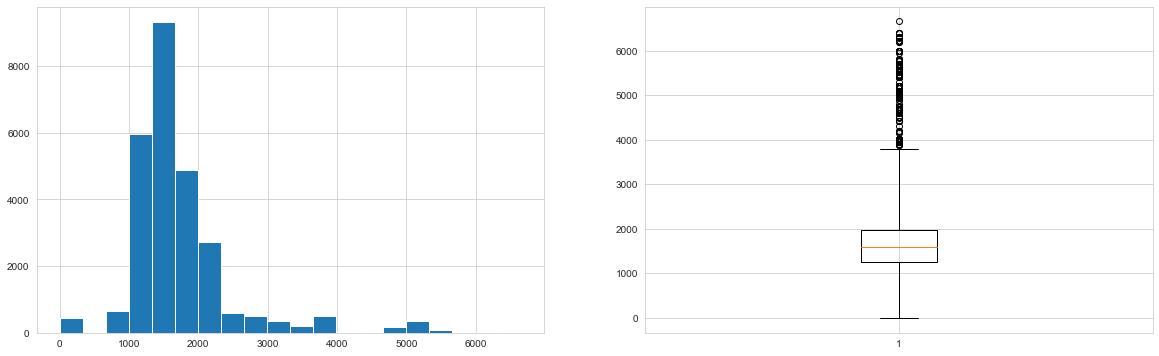

In [737]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["engine_size"], bins=20)

plt.subplot(122)
plt.boxplot(df["engine_size"], whis=2.5)

plt.show()

# gears

In [738]:
first_looking("gears")

COLUMN NAME    :  gears
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  11
--------------------------------
6.000     11661
5.000      7410
7.000      2582
8.000      2152
1.000      1313
9.000      1147
4.000       339
10.000      244
3.000        56
0.000        30
2.000         3
Name: gears, dtype: int64


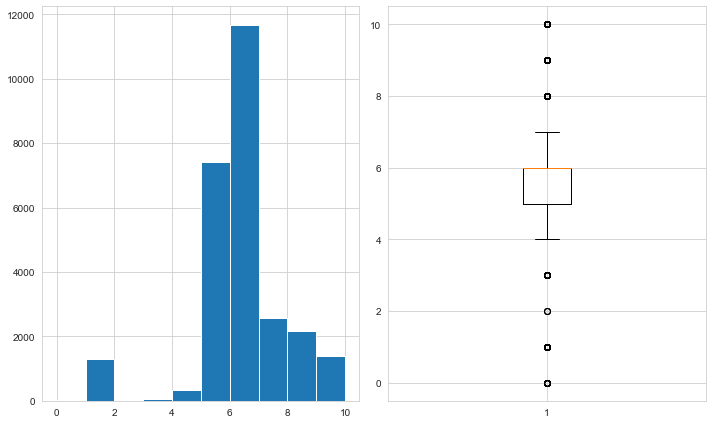

In [739]:
plt.subplot(121)
plt.hist(df.gears)

plt.subplot(122)
plt.boxplot(df.gears)

plt.tight_layout()
plt.show()

In [740]:
# I'll check potential outliers and exclude electric vehicles because they only have one gear

df[(df.gears < 3) & ~(df["fuel_type"] == "Electric") | (df.gears > 8)][["make_model", "body_type", "gearbox", "fuel_type", "gears"]]

,make_model,body_type,gearbox,fuel_type,gears
1,Mercedes-Benz EQE 350,Compact,Automatic,Electric,9.000
9,Mercedes-Benz A 200,Compact,Automatic,Diesel,1.000
24,Mercedes-Benz GLC 220,Compact,Automatic,Diesel,9.000
33,Mercedes-Benz E 220,Compact,Manual,Diesel,9.000
73,Mercedes-Benz V 220,Compact,Manual,Diesel,9.000
...,...,...,...,...,...
25492,Volvo C70,Convertible,Automatic,Benzine,1.000
26498,Volvo 240,Station wagon,Manual,Liquid/Natural Gas,1.000
26502,Volvo 240,Station wagon,Manual,Benzine,1.000
26823,Volvo 240,Sedan,Automatic,Benzine,1.000


In [741]:
df.loc[((df.gears < 3) & ~(df["fuel_type"] == "Electric") | (df.gears > 8)), 'gears'] = np.nan

In [742]:
df.gears.isnull().sum()

1806

In [743]:
fill(df, "make_model", "body_type", "gears", "mode")

COLUMN NAME    :  gears
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  9
--------------------------------
6.000    12574
5.000     7498
7.000     3138
8.000     2214
1.000     1094
4.000      346
3.000       56
0.000       16
2.000        1
Name: gears, dtype: int64


In [744]:
df[df.gears == 2]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
9565,Fiat 500,Fiat,500,10950.000,Compact,Used,No Warranty,13500.000,Automatic,Electric,...,No,Cloth,2.000,unefficient,17.000,23.000,3.900,11.000,Germany,No


In [745]:
df.drop(df.loc[df['gears']==2].index, inplace=True)

In [746]:
df.gears.value_counts(dropna=False)

6.000    12574
5.000     7498
7.000     3138
8.000     2214
1.000     1094
4.000      346
3.000       56
0.000       16
Name: gears, dtype: int64

In [747]:
df[df.gears == 0]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
5127,Renault ZOE,Renault,ZOE,21988.000,Compact,Used,No Warranty,55673.000,Automatic,Electric,...,No,Cloth,1.000,efficient,80.000,109.000,5.300,3.000,Germany,Yes
9132,Peugeot Partner,Peugeot,Partner,14990.000,Station wagon,Used,Available,60926.000,Automatic,Electric,...,Yes,Cloth,1.000,efficient,49.000,67.000,5.300,4.000,Belgium,Yes
9821,Fiat 500,Fiat,500,27765.000,Compact,Used,No Warranty,11100.000,Automatic,Electric,...,No,Cloth,1.000,efficient,87.000,118.000,3.900,1.000,Germany,Yes
17837,Toyota C-HR,Toyota,C-HR,18950.000,Off-Road/Pick-up,Used,Available,96167.000,Automatic,Electric,...,No,Cloth,3.000,unefficient,90.000,122.000,4.000,4.000,Italy,No
17853,Toyota C-HR,Toyota,C-HR,32800.000,Off-Road/Pick-up,Demonstration,No Warranty,19800.000,Automatic,Electric,...,No,Part/Full Leather,1.000,efficient,135.000,184.000,4.000,1.000,Italy,No
18010,Toyota Corolla,Toyota,Corolla,26000.000,Station wagon,Used,Available,49374.000,Automatic,Electric,...,No,Cloth,1.000,efficient,135.000,184.000,3.300,3.000,Italy,No
18031,Toyota Corolla,Toyota,Corolla,29450.000,Station wagon,Used,No Warranty,23000.000,Automatic,Electric,...,No,Cloth,1.000,efficient,72.000,98.000,3.600,1.000,Austria,No
18060,Toyota Corolla,Toyota,Corolla,26800.000,Station wagon,Used,Available,17227.000,Automatic,Electric,...,No,Cloth,2.000,efficient,132.000,179.000,3.300,3.000,Italy,No
18495,Toyota Yaris,Toyota,Yaris,17100.000,Sedan,Used,Available,26401.000,Automatic,Electric,...,No,Cloth,2.000,efficient,74.000,101.000,4.200,3.000,Italy,No
18510,Toyota Yaris,Toyota,Yaris,14500.000,Sedan,Used,Available,91000.000,Automatic,Electric,...,No,Cloth,1.000,efficient,74.000,101.000,3.600,3.000,Italy,No


In [748]:
# They are all electric vehicles

df['gears'].replace(0, 1, inplace=True)

In [749]:
df.gears.value_counts()

6.000    12574
5.000     7498
7.000     3138
8.000     2214
1.000     1110
4.000      346
3.000       56
Name: gears, dtype: int64

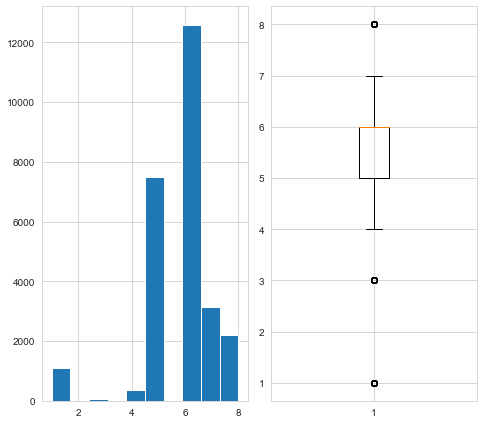

In [750]:
plt.subplot(131)
plt.hist(df.gears)

plt.subplot(132)
plt.boxplot(df.gears)

plt.tight_layout()
plt.show()

# empty_weight

In [751]:
first_looking("empty_weight")

COLUMN NAME    :  empty_weight
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  1218
--------------------------------
1320.000    715
1280.000    524
1395.000    471
1055.000    452
1165.000    400
           ... 
946.000       1
1631.000      1
2489.000      1
2133.000      1
1391.000      1
Name: empty_weight, Length: 1218, dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

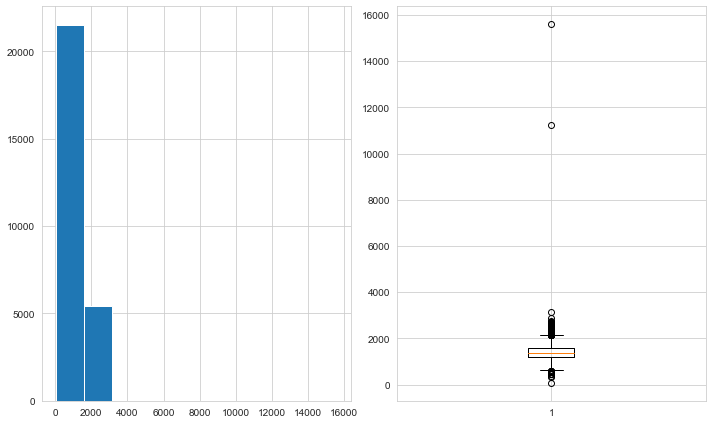

In [752]:
plt.subplot(121)
plt.hist(df.empty_weight)

plt.subplot(122)
plt.boxplot(df.empty_weight)

plt.tight_layout()
plt.show

In [753]:
df.empty_weight.describe()

count   26936.000
mean     1404.801
std       319.472
min        75.000
25%      1196.000
50%      1360.000
75%      1575.000
max     15590.000
Name: empty_weight, dtype: float64

In [754]:
df.empty_weight.sort_values(ascending=True).head(20)

14001    75.000
6171    347.000
6209    375.000
4949    473.000
5431    473.000
4844    473.000
4892    473.000
5785    474.000
4185    525.000
5748    562.000
5815    562.000
5935    562.000
5145    562.000
5918    562.000
9680    600.000
9684    600.000
12228   600.000
10659   600.000
5594    650.000
11850   670.000
Name: empty_weight, dtype: float64

In [755]:
df.empty_weight.sort_values(ascending=True).tail(20)

1268     2595.000
1331     2610.000
1421     2610.000
1480     2610.000
1258     2610.000
1342     2610.000
1355     2610.000
1448     2612.000
17814    2650.000
2159     2655.000
1629     2680.000
2202     2680.000
1199     2690.000
2374     2712.000
17798    2725.000
5415     2750.000
19958    2900.000
1293     3150.000
21047   11246.000
6882    15590.000
Name: empty_weight, dtype: float64

In [756]:
df.loc[df.empty_weight > 3150][["make_model", "body_type", "empty_weight"]]

,make_model,body_type,empty_weight
6882,Renault ZOE,Sedan,15590.000
21047,Ford Fiesta,Compact,11246.000


In [757]:
df.loc[df.make_model == "Renault ZOE"][['make_model', 'empty_weight']]

,make_model,empty_weight
4816,Renault ZOE,1577.000
4825,Renault ZOE,1577.000
4829,Renault ZOE,1428.000
4832,Renault ZOE,1577.000
4846,Renault ZOE,1428.000
...,...,...
7108,Renault ZOE,1577.000
7119,Renault ZOE,1577.000
7121,Renault ZOE,1577.000
7129,Renault ZOE,1577.000


In [758]:
df.empty_weight.replace({15590.0:1559.0}, inplace=True)

In [759]:
df.loc[df.make_model == "Ford Fiesta"][["make_model", "empty_weight"]]

,make_model,empty_weight
20690,Ford Fiesta,1063.000
20691,Ford Fiesta,1163.000
20692,Ford Fiesta,1063.000
20695,Ford Fiesta,1262.000
20697,Ford Fiesta,1262.000
...,...,...
23006,Ford Fiesta,1164.000
23007,Ford Fiesta,1164.000
23008,Ford Fiesta,1164.000
23010,Ford Fiesta,1055.000


In [760]:
df.empty_weight.replace({11246.0:1124.6}, inplace=True)

Domain Knowledge: Lightest car in our dataset is Renault Twizy which is around 450kg

In [761]:
df.loc[df.empty_weight < 500][["make_model", "empty_weight"]]

,make_model,empty_weight
4844,Renault Twizy,473.000
4892,Renault Twizy,473.000
4949,Renault Twizy,473.000
5431,Renault Twizy,473.000
5785,Renault Twizy,474.000
6171,Renault Twizy,347.000
6209,Renault Twizy,375.000
14001,Skoda Enyaq,75.000


In [762]:
df.loc[df.make_model == "Skoda Enyaq"][["make_model", "empty_weight"]]

,make_model,empty_weight
13983,Skoda Enyaq,2107.000
14001,Skoda Enyaq,75.000
14061,Skoda Enyaq,2107.000
14063,Skoda Enyaq,2107.000
14071,Skoda Enyaq,2107.000
14119,Skoda Enyaq,2107.000
14186,Skoda Enyaq,2107.000
14194,Skoda Enyaq,1992.000
14209,Skoda Enyaq,1992.000
14244,Skoda Enyaq,2107.000


In [763]:
df.loc[df.empty_weight < 100, 'empty_weight'] = np.nan

In [764]:
df.empty_weight.isna().sum()

1

In [765]:
fill(df, "make_model", "body_type", "empty_weight", "mode")

COLUMN NAME    :  empty_weight
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  1216
--------------------------------
1320.000    715
1280.000    524
1395.000    471
1055.000    452
1165.000    400
           ... 
2252.000      1
2725.000      1
2650.000      1
2712.000      1
1391.000      1
Name: empty_weight, Length: 1216, dtype: int64


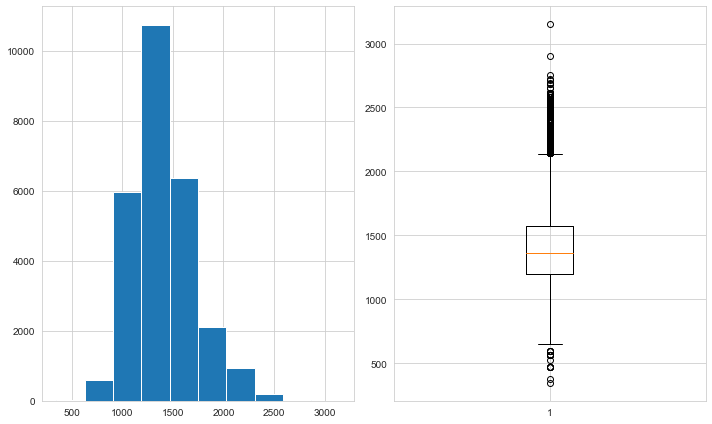

In [766]:
plt.subplot(121)
plt.hist(df.empty_weight)

plt.subplot(122)
plt.boxplot(df.empty_weight)

plt.tight_layout()
plt.show()

# co_emissions

In [767]:
first_looking("co_emissions")

COLUMN NAME    :  co_emissions
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  398
--------------------------------
0.000        1947
124.000       919
115.000       565
108.000       555
109.000       549
             ... 
5.000           1
304.000         1
1390.000        1
15168.000       1
53.000          1
Name: co_emissions, Length: 398, dtype: int64


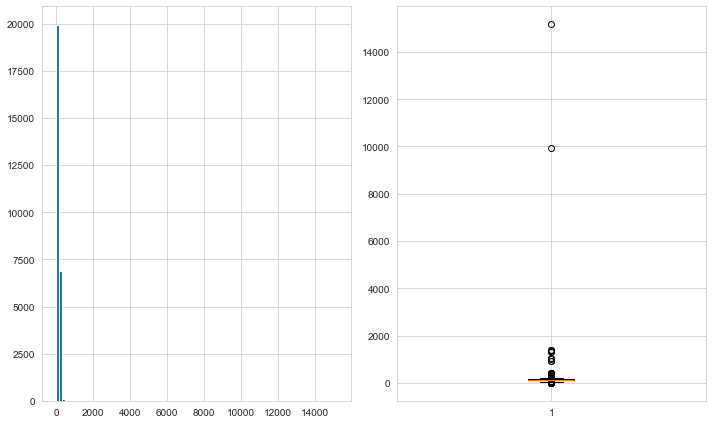

In [768]:
plt.subplot(121)
plt.hist(df.co_emissions, bins=100)

plt.subplot(122)
plt.boxplot(df.co_emissions)

plt.tight_layout()
plt.show()

In [769]:
df.co_emissions.describe()

count   26936.000
mean      130.731
std       125.731
min         0.000
25%       107.000
50%       124.000
75%       154.000
max     15168.000
Name: co_emissions, dtype: float64

In [770]:
df.co_emissions.sort_values(ascending=False).head(20)

9949    15168.000
20796    9954.000
17952    1410.000
10212    1390.000
4561     1360.000
11827    1320.000
9323     1060.000
25752    1000.000
21919     940.000
20707     910.000
21831     420.000
26188     414.000
607       400.000
21446     399.000
19433     398.000
21474     394.000
1297      377.000
1501      373.000
21458     350.000
21829     350.000
Name: co_emissions, dtype: float64

In [771]:
df.co_emissions.sort_values(ascending=False).tail(20)

17857   0.000
7780    0.000
17803   0.000
8045    0.000
17808   0.000
13411   0.000
24388   0.000
13395   0.000
13387   0.000
13386   0.000
2901    0.000
9655    0.000
17826   0.000
9656    0.000
13382   0.000
17827   0.000
17837   0.000
7830    0.000
17841   0.000
24640   0.000
Name: co_emissions, dtype: float64

In [772]:
df.loc[df.co_emissions > 350][["make_model", "body_type", "age", "engine_size", "fuel_type", "co_emissions"]]\
                                .sort_values(by=["co_emissions"], ascending=False)

,make_model,body_type,age,engine_size,fuel_type,co_emissions
9949,Fiat 124 Spider,Convertible,4.000,1368.000,Benzine,15168.000
20796,Ford Focus,Compact,2.000,998.000,Benzine,9954.000
17952,Toyota Avensis,Station wagon,11.000,1998.000,Diesel,1410.000
10212,Fiat 500,Convertible,5.000,1368.000,Benzine,1390.000
4561,Opel Astra,Sedan,3.000,1399.000,Benzine,1360.000
11827,Fiat Tipo,Sedan,6.000,1368.000,Benzine,1320.000
9323,Peugeot 308,Sedan,2.000,1499.000,Diesel,1060.000
25752,Volvo C30,Coupe,13.000,1800.000,Benzine,1000.000
21919,Ford Edge,Off-Road/Pick-up,2.000,1995.000,Diesel,940.000
20707,Ford Fiesta,Compact,1.000,1496.000,Benzine,910.000


In [773]:
df.loc[df.fuel_type == "Electric"]["co_emissions"].value_counts()

0.000      1083
88.000       48
92.000       39
34.000       20
76.000       20
           ... 
71.000        1
159.000       1
117.000       1
104.000       1
191.000       1
Name: co_emissions, Length: 134, dtype: int64

In [774]:
# I'll only select the ones that has more than 400 co2 emission because Ford Mustang, GTR, Mercedes G
# can have co2 emission 400 and below.

In [775]:
df.loc[df.co_emissions > 400][["co_emissions"]].values

array([[ 1360.],
       [ 1060.],
       [15168.],
       [ 1390.],
       [ 1320.],
       [ 1410.],
       [  910.],
       [ 9954.],
       [  420.],
       [  940.],
       [ 1000.],
       [  414.]])

In [776]:
outlier_co2 = df.co_emissions.isin([1360.,
       1060.,
       15168.,
       1390.,
       1320.,
       1410.,
       910.,
       9954.,
       420.,
       940.,
       1000.,
       414.])

df.loc[outlier_co2, "co_emissions"] = np.nan

In [777]:
df.co_emissions.isnull().sum()

12

In [778]:
fill(df, "make_model", "body_type", "co_emissions", "median")

COLUMN NAME    :  co_emissions
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  386
--------------------------------
0.000      1947
124.000     919
115.000     565
108.000     555
109.000     549
           ... 
316.000       1
348.000       1
373.000       1
146.750       1
53.000        1
Name: co_emissions, Length: 386, dtype: int64


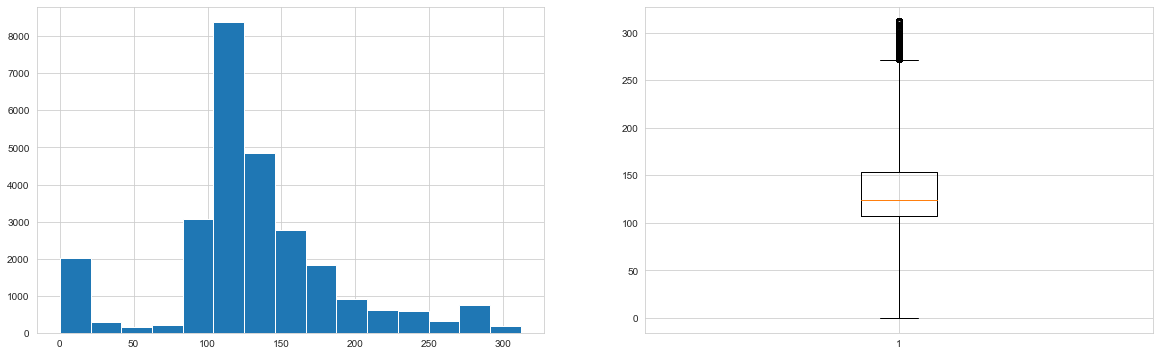

In [779]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(winsorize(df["co_emissions"], (0.001, 0.003)), bins = 15)

plt.subplot(122)
plt.boxplot(winsorize(df["co_emissions"], (0.001, 0.003)), whis=2.5)

plt.show()

# fuel_consumption_avg

In [780]:
first_looking("fuel_consumption_avg")

COLUMN NAME    :  fuel_consumption_avg
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  221
--------------------------------
5.300    1360
4.900    1021
5.000    1009
5.100     847
4.500     801
         ... 
4.550       1
8.550       1
6.200       1
4.250       1
0.750       1
Name: fuel_consumption_avg, Length: 221, dtype: int64


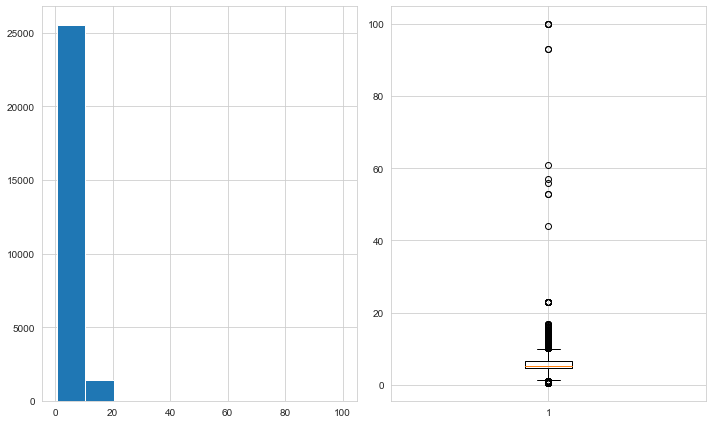

In [781]:
plt.subplot(121)
plt.hist(df.fuel_consumption_avg)

plt.subplot(122)
plt.boxplot(df.fuel_consumption_avg)

plt.tight_layout()
plt.show()

In [782]:
df.fuel_consumption_avg.sort_values(ascending=False).head(20)

263     99.900
22912   99.900
18712   99.900
18711   99.900
20921   93.000
20904   93.000
1771    61.000
6585    57.000
18458   56.000
24061   53.000
23888   53.000
19826   44.000
21329   23.000
21364   23.000
21271   23.000
21125   23.000
21250   23.000
21249   23.000
21247   23.000
21381   23.000
Name: fuel_consumption_avg, dtype: float64

In [783]:
df.fuel_consumption_avg.sort_values(ascending=False).tail(20)

2231    0.650
17606   0.600
2377    0.600
1941    0.600
2386    0.600
1962    0.600
1733    0.600
1819    0.600
1895    0.600
1925    0.600
17797   0.600
9091    0.500
8763    0.500
9087    0.500
9072    0.500
9071    0.500
11291   0.500
8744    0.500
9034    0.500
9067    0.500
Name: fuel_consumption_avg, dtype: float64

In [784]:
df.loc[df.fuel_consumption_avg > 23][["make_model", "fuel_type", "fuel_consumption_avg"]]

,make_model,fuel_type,fuel_consumption_avg
263,Mercedes-Benz A 180,Benzine,99.900
1771,Mercedes-Benz E 200,Benzine,61.000
6585,Renault Megane,Benzine,57.000
18458,Toyota Yaris,Benzine,56.000
18711,Nissan Qashqai,Benzine,99.900
18712,Nissan Qashqai,Benzine,99.900
19826,Nissan Qashqai,Diesel,44.000
20904,Ford Focus,Diesel,93.000
20921,Ford Focus,Diesel,93.000
22912,Ford Focus,Diesel,99.900


In [785]:
df.loc[df.fuel_consumption_avg >= 20][["fuel_consumption_avg"]].values

array([[99.9],
       [61. ],
       [57. ],
       [56. ],
       [99.9],
       [99.9],
       [44. ],
       [93. ],
       [93. ],
       [23. ],
       [23. ],
       [23. ],
       [23. ],
       [23. ],
       [23. ],
       [23. ],
       [23. ],
       [23. ],
       [23. ],
       [99.9],
       [53. ],
       [53. ]])

In [786]:
outlier_cons = df.fuel_consumption_avg.isin([99.9,
       61.,
       57.,
       56.,
       44.,
       93.,
       53.,
       23.,])

df.loc[outlier_cons, "fuel_consumption_avg"] = np.nan

In [787]:
df.fuel_consumption_avg.isna().sum()

22

In [788]:
fill(df, "make_model", "body_type", "fuel_consumption_avg", "median")

COLUMN NAME    :  fuel_consumption_avg
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  213
--------------------------------
5.300    1362
4.900    1021
5.000    1009
5.100     847
4.500     801
         ... 
4.250       1
1.450       1
6.200       1
8.550       1
8.650       1
Name: fuel_consumption_avg, Length: 213, dtype: int64


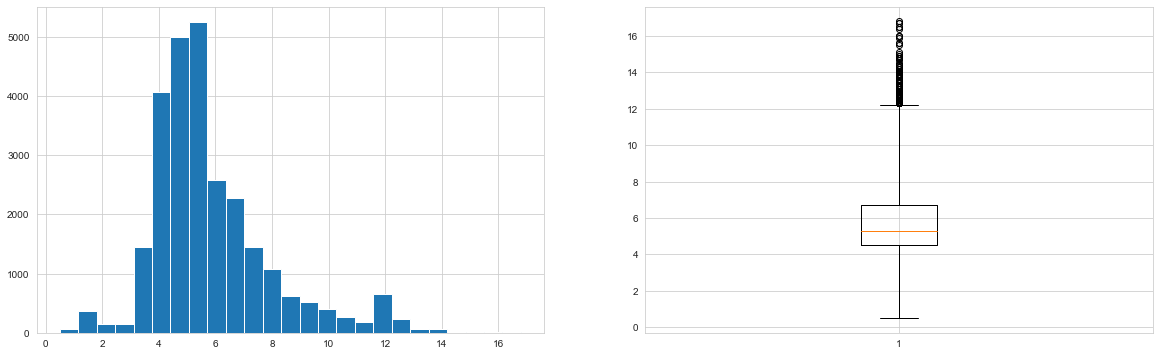

In [789]:
plt.figure(figsize = (20, 6))

plt.subplot(121)
plt.hist(df.fuel_consumption_avg, bins = 25)

plt.subplot(122)
plt.boxplot(df.fuel_consumption_avg, whis=2.5)

plt.show()

# previous_owner

In [790]:
first_looking("previous_owner")

COLUMN NAME    :  previous_owner
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  14
--------------------------------
1.000     16643
2.000      6771
3.000      1606
0.000      1060
4.000       465
5.000       192
6.000        80
7.000        54
8.000        41
9.000        16
12.000        4
10.000        2
14.000        1
13.000        1
Name: previous_owner, dtype: int64


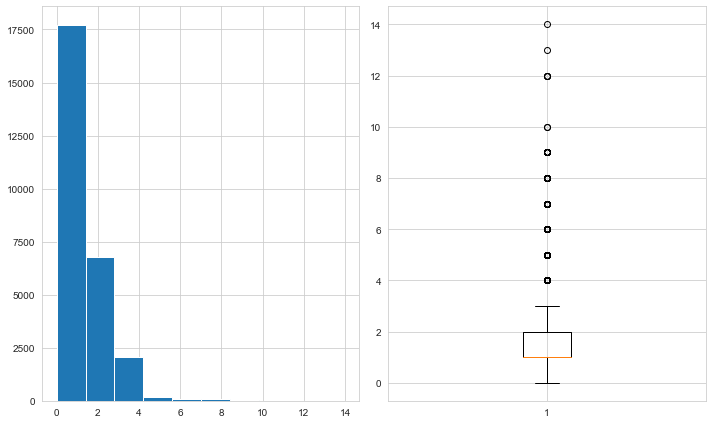

In [791]:
plt.subplot(121)
plt.hist(df.previous_owner)

plt.subplot(122)
plt.boxplot(df.previous_owner)

plt.tight_layout()
plt.show()

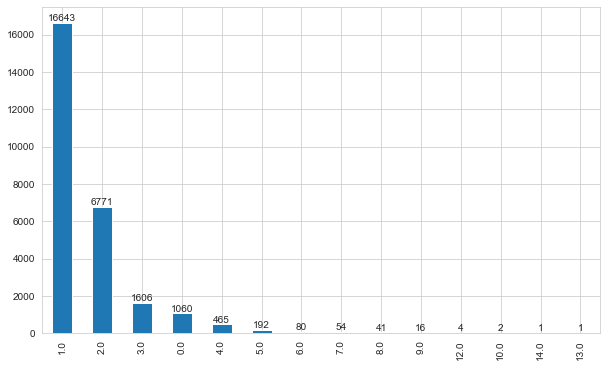

In [792]:
fig, ax = plt.subplots()

df.previous_owner.value_counts(dropna=False).plot.bar()

for i in ax.containers:
    ax.bar_label(i)

In [793]:
df.loc[(df.previous_owner > 8)&(df.age < 18)][["make_model", "age", "mileage", "previous_owner"]]

,make_model,age,mileage,previous_owner
6548,Renault Clio,7.000,124935.000,9.000
6566,Renault Grand Scenic,7.000,122700.000,9.000
7556,Peugeot 207,15.000,188790.000,14.000
9862,Fiat 500,6.000,50999.000,9.000
19315,Nissan 370Z,12.000,114117.000,12.000


In [794]:
drop_pre_owner = df[df.previous_owner >= 10].index
drop_pre_owner

Int64Index([7262, 7556, 7830, 17449, 19315, 26513, 26543, 26719], dtype='int64')

In [795]:
df.shape

(26936, 31)

In [796]:
df.drop(drop_pre_owner, inplace=True)

In [797]:
df.shape

(26928, 31)

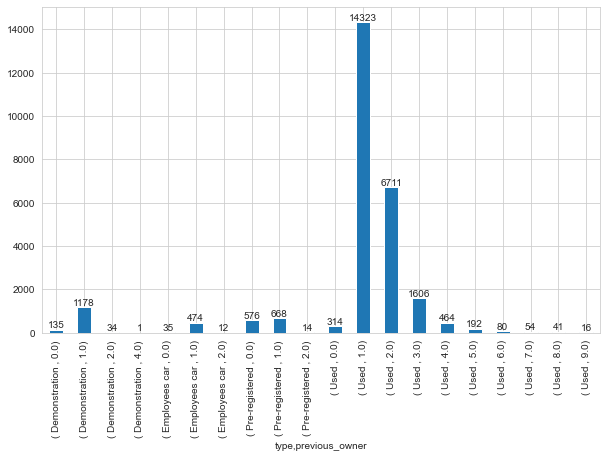

In [798]:
fig, ax = plt.subplots()

df.groupby(["type", "previous_owner"])["previous_owner"].count().plot.bar()

for container in ax.containers:
    ax.bar_label(container)

# age

In [799]:
first_looking("age")

COLUMN NAME    :  age
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  82
--------------------------------
3.000     3504
4.000     3305
0.000     2837
1.000     2734
2.000     2396
          ... 
89.000       1
-3.000       1
76.000       1
66.000       1
69.000       1
Name: age, Length: 82, dtype: int64


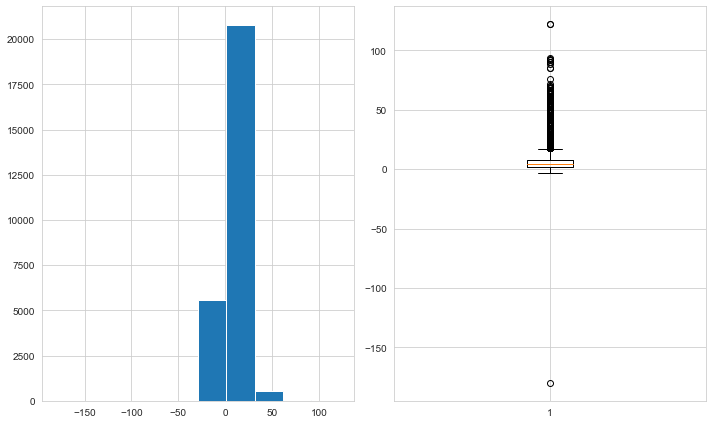

In [800]:
plt.subplot(121)
plt.hist(df.age)

plt.subplot(122)
plt.boxplot(df.age)

plt.tight_layout()
plt.show()

In [801]:
df.age.describe()

count   26928.000
mean        6.722
std         8.666
min      -180.000
25%         2.000
50%         4.000
75%         8.000
max       122.000
Name: age, dtype: float64

In [802]:
df.age.sort_values(ascending=False).head(20)

21968   122.000
24706   122.000
21277    94.000
21105    93.000
8045     92.000
21221    92.000
21366    90.000
21291    90.000
21242    90.000
10051    89.000
21254    85.000
21359    85.000
9307     76.000
3358     72.000
769      70.000
5305     70.000
25747    69.000
21237    68.000
10583    68.000
25717    68.000
Name: age, dtype: float64

In [803]:
df.age.sort_values(ascending=False).tail(20)

15165      0.000
24551      0.000
24552      0.000
15163      0.000
1396       0.000
18521      0.000
6230       0.000
16733      0.000
24567      0.000
24558      0.000
16566      0.000
24560      0.000
18516      0.000
13288      0.000
11474      0.000
11472      0.000
24565      0.000
24566      0.000
9815      -3.000
7020    -180.000
Name: age, dtype: float64

In [804]:
df.loc[df.age > 34][["make_model", "mileage", "age"]]

,make_model,mileage,age
88,Mercedes-Benz E 300,208608.000,36.000
279,Mercedes-Benz 280,457379.000,37.000
448,Mercedes-Benz 230,96796.000,56.000
512,Mercedes-Benz 230,88000.000,39.000
534,Mercedes-Benz SL 300,235964.000,35.000
...,...,...,...
25763,Volvo Amazon,87562.000,56.000
25764,Volvo 480,91700.000,35.000
26495,Volvo P1800,96200.000,49.000
26815,Volvo 244,222606.000,43.000


In [805]:
# Due to the fact that we have very few old cars I'll drop them to train our machine better.

drop_age = df.loc[(df["age"] > 34) | (df["age"] < 0)].index
drop_age

Int64Index([   88,   279,   448,   512,   534,   553,   568,   575,   610,
              613,
            ...
            25717, 25724, 25747, 25758, 25762, 25763, 25764, 26495, 26815,
            26823],
           dtype='int64', length=489)

In [806]:
df.shape

(26928, 31)

In [807]:
df.drop(drop_age, axis=0, inplace=True)

In [808]:
df.shape

(26439, 31)

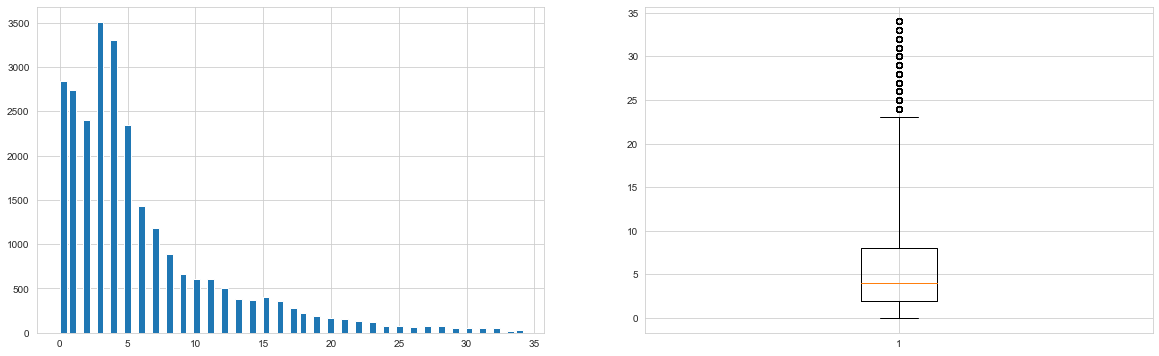

In [809]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.hist(df["age"], bins=100, width=0.5)

plt.subplot(122)
plt.boxplot(df["age"], whis=2.5)

plt.show()

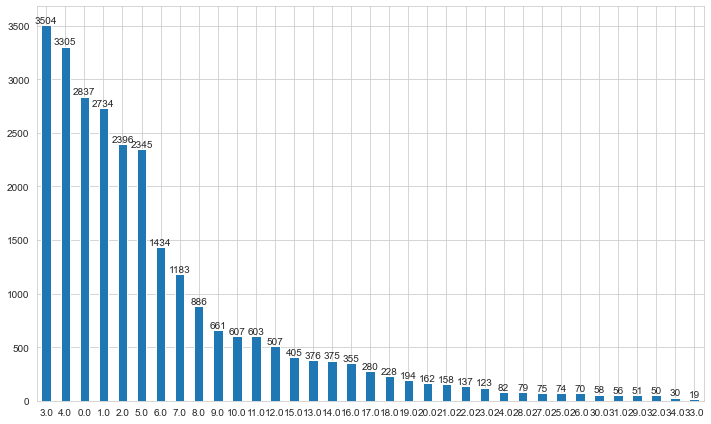

In [810]:
fig, ax = plt.subplots()

df.age.value_counts(dropna=False).plot.bar()

plt.xticks(rotation = 0)

plt.tight_layout()

for i in ax.containers:
    ax.bar_label(i)

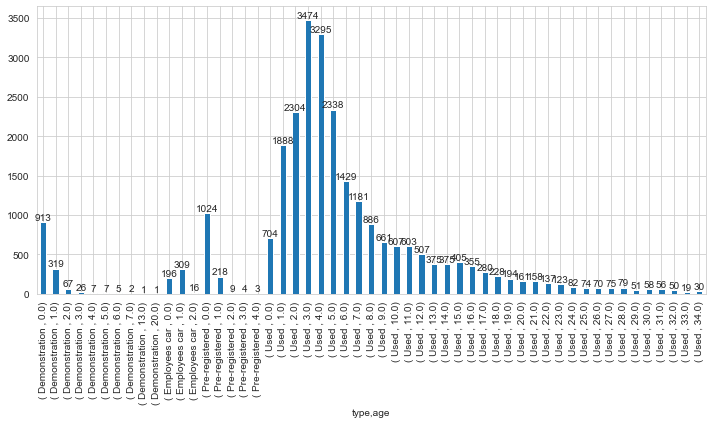

In [811]:
fig, ax = plt.subplots()

df.groupby(["type", "age"])["age"].count().plot.bar()

plt.tight_layout()

for i in ax.containers:
    ax.bar_label(i)

# power_kW

In [812]:
first_looking("power_kW")

COLUMN NAME    :  power_kW
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  335
--------------------------------
110.000    1813
96.000     1446
66.000     1129
81.000     1112
88.000     1067
           ... 
810.000       1
665.000       1
883.000       1
296.000       1
284.000       1
Name: power_kW, Length: 335, dtype: int64


In [813]:
df.power_kW.describe()

count   26439.000
mean      118.440
std        68.638
min         1.000
25%        80.000
50%        98.000
75%       135.000
max       924.000
Name: power_kW, dtype: float64

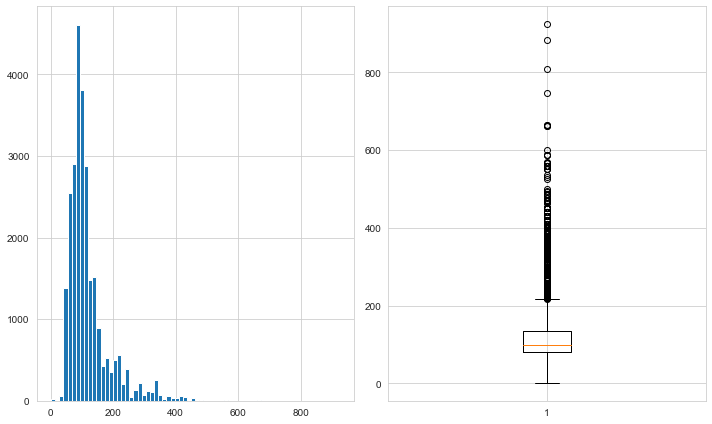

In [814]:
plt.subplot(121)
plt.hist(df.power_kW, bins=70)

plt.subplot(122)
plt.boxplot(df.power_kW)

plt.tight_layout()
plt.show()

In [815]:
df.power_kW.sort_values(ascending=False).head(25)

17236   924.000
19379   883.000
19409   810.000
19198   746.000
19383   665.000
19494   664.000
21680   662.000
17214   662.000
19444   600.000
1073    588.000
19393   588.000
1450    588.000
19186   570.000
21569   567.000
21446   567.000
21474   567.000
21709   559.000
21726   559.000
21688   559.000
21689   559.000
21685   559.000
21702   559.000
21729   559.000
21824   559.000
21699   559.000
Name: power_kW, dtype: float64

In [816]:
df.loc[df.power_kW > 500][["make_model", "engine_size", "fuel_type", "power_kW"]]

,make_model,engine_size,fuel_type,power_kW
1024,Mercedes-Benz S 63 AMG,5461.000,Benzine,537.000
1073,Mercedes-Benz GLE 63 AMG,3982.000,Benzine,588.000
1450,Mercedes-Benz GLE 63 AMG,3982.000,Benzine,588.000
17214,Toyota Supra,2997.000,Benzine,662.000
17236,Toyota Supra,2997.000,Benzine,924.000
19186,Nissan Skyline,2740.000,Benzine,570.000
19198,Nissan GT-R,3799.000,Benzine,746.000
19379,Nissan GT-R,3799.000,Benzine,883.000
19383,Nissan GT-R,3799.000,Benzine,665.000
19393,Nissan GT-R,3799.000,Benzine,588.000


In [817]:
df.power_kW.sort_values(ascending=False).tail(30)

15648   32.000
5147    31.000
9600    29.000
9727    29.000
5208    25.000
12231   25.000
10292   24.000
10680   20.000
16326   19.000
9684    18.000
16392   18.000
16337   18.000
4892    13.000
4844    12.000
5835    12.000
5145     9.000
5815     8.000
5918     8.000
5951     8.000
5545     7.000
24343    6.000
5748     4.000
6209     4.000
6171     4.000
5935     4.000
5785     4.000
22011    3.000
7559     1.000
5178     1.000
5431     1.000
Name: power_kW, dtype: float64

In [818]:
df.loc[(df.power_kW < 20) & ~(df.fuel_type == "Electric")][["make_model", "fuel_type", "power_kW"]]

,make_model,fuel_type,power_kW
5545,Renault Megane,Benzine,7.000
5835,Renault Megane,Benzine,12.000
5951,Renault Megane,Diesel,8.000
7559,Peugeot 205,Benzine,1.000
9684,Fiat 126,Benzine,18.000
22011,Ford Kuga,Diesel,3.000
24343,Hyundai i20,Benzine,6.000


In [819]:
outlier_powerkw = df.loc[(df.power_kW < 20) & ~(df.fuel_type == "Electric")][["power_kW"]].index
outlier_powerkw

Int64Index([5545, 5835, 5951, 7559, 9684, 22011, 24343], dtype='int64')

In [822]:
df.loc[outlier_powerkw, "power_kW"] = np.nan

In [823]:
df.power_kW.isna().sum()

7

In [824]:
fill(df, "make_model", "body_type", "power_kW", "median")

COLUMN NAME    :  power_kW
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  333
--------------------------------
110.000    1814
96.000     1447
66.000     1129
81.000     1112
88.000     1067
           ... 
296.000       1
164.000       1
246.000       1
363.000       1
242.000       1
Name: power_kW, Length: 333, dtype: int64


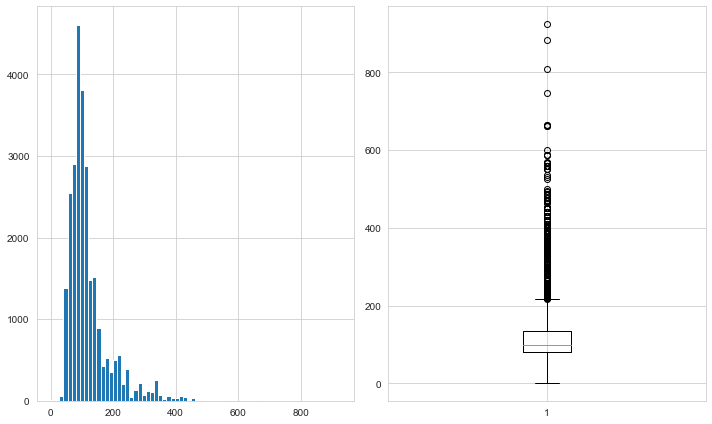

In [825]:
plt.subplot(121)
plt.hist(df.power_kW, bins=70)

plt.subplot(122)
plt.boxplot(df.power_kW)

plt.tight_layout()
plt.show()

In [826]:
df.sample(3).T

,15306,10818,13944
make_model,Dacia Sandero,Fiat 500X,Skoda Fabia
make,Dacia,Fiat,Skoda
model,Sandero,500X,Fabia
price,11500.000,31899.000,10208.000
body_type,Compact,Off-Road/Pick-up,Compact
type,Used,Pre-registered,Used
warranty,Available,Available,Available
mileage,34000.000,10.000,113894.000
gearbox,Manual,Automatic,Manual
fuel_type,Benzine,Benzine,Benzine


# model

In [827]:
first_looking("model")

COLUMN NAME    :  model
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  549
--------------------------------
 Megane           865
 Leon             769
 Sandero          726
 i30              701
 Astra            680
                 ... 
 Master             1
 Express            1
 Grand Espace       1
 CLS 320            1
 R 21               1
Name: model, Length: 549, dtype: int64


In [829]:
df.loc[df.model == "  "]

,make_model,make,model,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,non_smoker_vehicle,upholstery,previous_owner,energy_efficiency_class,power_kW,power_hp,fuel_consumption_avg,age,country,multimedia
162,Mercedes-Benz,Mercedes-Benz,,30490.000,Compact,Used,No Warranty,28539.000,Manual,Diesel,...,No,Part/Full Leather,1.000,unefficient,85.000,116.000,3.900,1.000,France,Yes
184,Mercedes-Benz,Mercedes-Benz,,22790.000,Compact,Used,No Warranty,47638.000,Automatic,Diesel,...,No,Part/Full Leather,1.000,efficient,80.000,109.000,3.900,5.000,France,No
186,Mercedes-Benz,Mercedes-Benz,,28790.000,Compact,Used,No Warranty,24045.000,Manual,Diesel,...,No,Part/Full Leather,1.000,efficient,85.000,116.000,3.900,3.000,France,Yes
211,Mercedes-Benz,Mercedes-Benz,,18390.000,Compact,Used,No Warranty,66574.000,Manual,Diesel,...,No,Part/Full Leather,1.000,efficient,66.000,90.000,3.900,5.000,France,No
213,Mercedes-Benz,Mercedes-Benz,,28290.000,Compact,Used,No Warranty,22888.000,Manual,Diesel,...,No,Part/Full Leather,1.000,efficient,85.000,116.000,3.900,3.000,France,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24572,Hyundai,Hyundai,,21991.000,Sedan,Demonstration,No Warranty,7419.000,Manual,Benzine,...,Yes,Cloth,1.000,unefficient,74.000,101.000,5.700,1.000,Germany,Yes
25541,Volvo,Volvo,,9900.000,Convertible,Used,Available,203190.000,Manual,Benzine,...,Yes,Part/Full Leather,3.000,efficient,103.000,140.000,8.900,15.000,Netherlands,No
25887,Volvo,Volvo,,68890.000,Off-Road/Pick-up,Demonstration,No Warranty,3500.000,Automatic,Electric,...,Yes,Part/Full Leather,1.000,efficient,300.000,408.000,8.900,0.000,Germany,Yes
25903,Volvo,Volvo,,64900.000,Off-Road/Pick-up,Demonstration,No Warranty,5163.000,Automatic,Electric,...,Yes,Cloth,1.000,efficient,300.000,408.000,8.900,0.000,Germany,Yes


In [832]:
df.loc[df.make == "Mercedes-Benz"][["make_model", "body_type", "engine_size"]].sample(20)

,make_model,body_type,engine_size
1289,Mercedes-Benz GLC 200,Off-Road/Pick-up,1991.000
1959,Mercedes-Benz C 300,Station wagon,1991.000
1033,Mercedes-Benz CLS,Coupe,1950.000
2078,Mercedes-Benz E 53 AMG,Sedan,2999.000
207,Mercedes-Benz A 180,Compact,1595.000
1038,Mercedes-Benz S 400,Coupe,2996.000
572,Mercedes-Benz E 200,Convertible,1991.000
537,Mercedes-Benz SLC 200,Convertible,1991.000
1801,Mercedes-Benz EQS,Station wagon,0.000
1492,Mercedes-Benz GLC 300,Off-Road/Pick-up,1950.000


In [834]:
nomodel = df.loc[df.model == "  "].index

In [836]:
df.shape

(26439, 31)

In [838]:
df.drop(nomodel, inplace=True)

In [839]:
df.shape

(26229, 31)

# cylinders

In [840]:
first_looking("cylinders")

COLUMN NAME    :  cylinders
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  12
--------------------------------
4.000     18229
3.000      4999
6.000      1201
8.000       819
5.000       547
0.000       184
1.000       133
2.000        99
12.000       11
7.000         5
26.000        1
16.000        1
Name: cylinders, dtype: int64


In [841]:
df.loc[(df.cylinders == 7) | (df.cylinders == 26) | (df.cylinders == 16)][["make_model", "engine_size", "cylinders"]]

,make_model,engine_size,cylinders
5612,Renault Arkana,1333.000,7.000
5615,Renault Arkana,1333.000,7.000
5624,Renault Arkana,1333.000,7.000
5835,Renault Megane,1998.000,26.000
6566,Renault Grand Scenic,1600.000,7.000
21228,Ford Mustang,4600.000,7.000
24869,Hyundai Matrix,1599.000,16.000


In [842]:
df.loc[df.make_model == "Renault Arkana"][["make_model", "engine_size", "cylinders"]]

,make_model,engine_size,cylinders
5612,Renault Arkana,1333.000,7.000
5615,Renault Arkana,1333.000,7.000
5618,Renault Arkana,1333.000,4.000
5622,Renault Arkana,1333.000,4.000
5623,Renault Arkana,1333.000,4.000
...,...,...,...
6323,Renault Arkana,1598.000,4.000
6796,Renault Arkana,1332.000,4.000
6806,Renault Arkana,1332.000,4.000
6849,Renault Arkana,1332.000,4.000


In [844]:
outlier_cylinder = df.loc[(df.cylinders == 7) | (df.cylinders == 26) | (df.cylinders == 16)][["make_model", "engine_size", "cylinders"]].index
outlier_cylinder

Int64Index([5612, 5615, 5624, 5835, 6566, 21228, 24869], dtype='int64')

In [845]:
df.loc[outlier_cylinder, "cylinders"] = np.nan

In [846]:
df.cylinders.isna().sum()

7

In [847]:
fill(df, "make_model", "body_type", "cylinders", "mode")

COLUMN NAME    :  cylinders
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  9
--------------------------------
4.000     18235
3.000      4999
6.000      1201
8.000       820
5.000       547
0.000       184
1.000       133
2.000        99
12.000       11
Name: cylinders, dtype: int64


In [855]:
df.loc[(df.cylinders == 1) & ~(df.fuel_type == "Electric")][["make_model", "engine_size", "fuel_type", "fuel_consumption_avg", "cylinders"]]

,make_model,engine_size,fuel_type,fuel_consumption_avg,cylinders
5753,Renault R 5,1400.000,Benzine,6.800,1.000
24723,Hyundai IONIQ 5,1.000,Benzine,5.300,1.000


In [863]:
df.loc[(df.make_model == "Hyundai IONIQ 5")][["make_model", "body_type", "cylinders", "fuel_consumption_avg", "fuel_type"]]

,make_model,body_type,cylinders,fuel_consumption_avg,fuel_type
23723,Hyundai IONIQ 5,Off-Road/Pick-up,1.000,5.300,Electric
24071,Hyundai IONIQ 5,Off-Road/Pick-up,1.000,5.300,Electric
24515,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric
24516,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric
24523,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric
24524,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric
24576,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric
24577,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric
24579,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric
24627,Hyundai IONIQ 5,Sedan,1.000,5.300,Electric


In [869]:
df.loc[(df.cylinders == 1) & ~(df.fuel_type == "Electric") & (df.make_model == 'Hyundai IONIQ 5'), "fuel_type"] = df.loc[(df.cylinders == 1) & ~(df.fuel_type == "Electric") & (df.make_model == 'Hyundai IONIQ 5'), "fuel_type"].replace("Benzine", "Electric")

In [870]:
df.loc[(df.cylinders == 1) & ~(df.fuel_type == "Electric")][["make_model", "engine_size", "fuel_type", "fuel_consumption_avg", "cylinders"]]

,make_model,engine_size,fuel_type,fuel_consumption_avg,cylinders
5753,Renault R 5,1400.000,Benzine,6.800,1.000


In [873]:
outlier_cylinder2 =df.loc[(df.cylinders == 1) & ~(df.fuel_type == "Electric")][["make_model", "engine_size", "fuel_type", "fuel_consumption_avg", "cylinders"]].index

In [874]:
df.loc[outlier_cylinder2, "cylinders"] = np.nan

In [875]:
df.cylinders.isna().sum()

1

In [877]:
fill(df, "make_model", "body_type", "cylinders", "mode")

COLUMN NAME    :  cylinders
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  9
--------------------------------
4.000     18236
3.000      4999
6.000      1201
8.000       820
5.000       547
0.000       184
1.000       132
2.000        99
12.000       11
Name: cylinders, dtype: int64


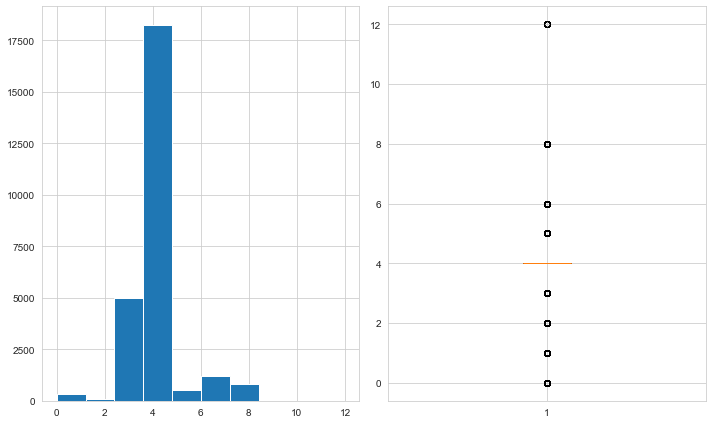

In [882]:
plt.subplot(121)
plt.hist(df.cylinders)

plt.subplot(122)
plt.boxplot(df.cylinders)

plt.tight_layout()
plt.show()

# num_comfort_convenience

In [884]:
first_looking("num_comfort_convenience")

COLUMN NAME    :  num_comfort_convenience
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  34
--------------------------------
3.000     1858
5.000     1454
6.000     1391
7.000     1269
4.000     1168
8.000     1150
20.000    1084
16.000    1050
18.000    1043
15.000    1038
17.000    1037
19.000    1015
11.000    1006
14.000    1004
10.000     977
12.000     965
9.000      911
13.000     899
2.000      890
1.000      840
21.000     818
22.000     797
23.000     669
24.000     620
25.000     391
26.000     336
27.000     189
28.000     137
29.000     100
30.000      70
31.000      33
32.000      12
33.000       7
34.000       1
Name: num_comfort_convenience, dtype: int64


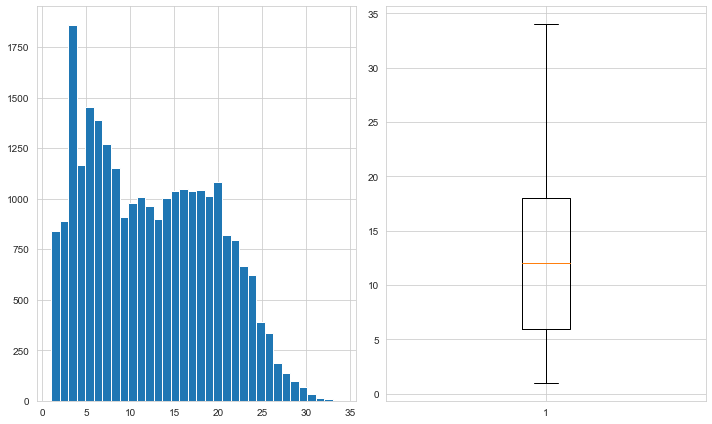

In [887]:
plt.subplot(121)
plt.hist(df.num_comfort_convenience, bins=34)

plt.subplot(122)
plt.boxplot(df.num_comfort_convenience)

plt.tight_layout()
plt.show()

# num_safety_security

In [888]:
first_looking("num_safety_security")

COLUMN NAME    :  num_safety_security
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  36
--------------------------------
9.000     1683
8.000     1359
10.000    1358
12.000    1353
14.000    1307
11.000    1295
13.000    1269
7.000     1263
1.000     1204
15.000    1139
16.000    1055
6.000      990
17.000     969
18.000     946
19.000     888
22.000     868
21.000     828
23.000     791
20.000     778
24.000     759
25.000     683
26.000     654
3.000      538
4.000      519
5.000      481
27.000     359
28.000     261
2.000      237
30.000     148
29.000     136
31.000      53
32.000      26
34.000      18
33.000      12
36.000       1
35.000       1
Name: num_safety_security, dtype: int64


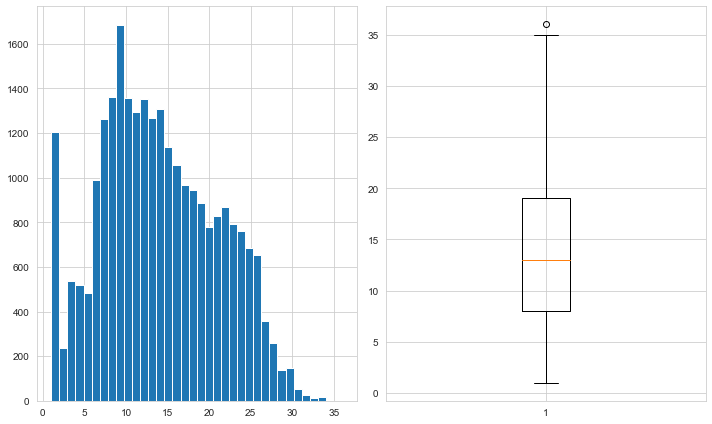

In [890]:
plt.subplot(121)
plt.hist(df.num_safety_security, bins=36)

plt.subplot(122)
plt.boxplot(df.num_safety_security)

plt.tight_layout()
plt.show()

# num_extras

In [891]:
first_looking("num_extras")

COLUMN NAME    :  num_extras
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  21
--------------------------------
1.000     7763
2.000     3390
3.000     2805
4.000     2236
5.000     1945
6.000     1567
7.000     1522
8.000     1081
9.000      961
10.000     845
11.000     625
12.000     509
13.000     355
14.000     251
15.000     192
16.000      96
17.000      50
18.000      23
19.000      10
20.000       2
26.000       1
Name: num_extras, dtype: int64


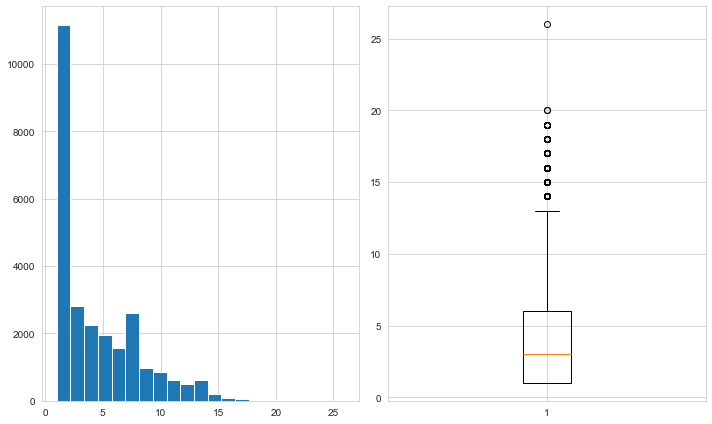

In [893]:
plt.subplot(121)
plt.hist(df.num_extras, bins=21)

plt.subplot(122)
plt.boxplot(df.num_extras)

plt.tight_layout()
plt.show()

In [896]:
df.loc[df.num_extras > 18][["make_model", "num_extras"]]

,make_model,num_extras
858,Mercedes-Benz AMG GT,19.000
1239,Mercedes-Benz GL 63 AMG,19.000
1480,Mercedes-Benz G 350,20.000
13197,SEAT Leon,19.000
13202,SEAT Leon,19.000
21965,Ford Edge,19.000
22162,Ford Kuga,19.000
22174,Ford Kuga,19.000
22186,Ford Kuga,19.000
22198,Ford Kuga,19.000


In [906]:
outlier_extras = df.loc[df.num_extras > 20].index
outlier_extras

Int64Index([25860], dtype='int64')

In [907]:
df.loc[outlier_extras, "num_extras"] = np.nan

In [908]:
df.num_extras.isna().sum()

1

In [909]:
fill(df, "make_model", "body_type", "num_extras", "mode")

COLUMN NAME    :  num_extras
--------------------------------
per_of_nulls   :  % 0.0
num_of_nulls   :  0
num_of_uniques :  20
--------------------------------
1.000     7764
2.000     3390
3.000     2805
4.000     2236
5.000     1945
6.000     1567
7.000     1522
8.000     1081
9.000      961
10.000     845
11.000     625
12.000     509
13.000     355
14.000     251
15.000     192
16.000      96
17.000      50
18.000      23
19.000      10
20.000       2
Name: num_extras, dtype: int64


# DONE